# Within-host single nucleotide variants 

**Date**: originally written on 2019-09-23, modified on 2020-01-09  
**Author**: Katarina Braun 


## Overview
- Look at the frequency of each SNP in each ferret over the course of within-host infections
- These SNVs were generated with the `Sniffles` pipeline 
- Using the CSV files that I generated in the `Visualizing_snps_single_timepoint` pipeline as input 
- Concatenate dataframes for all index animals in each virus group (GD3 (including recombinant viruses) Anhui, CA04) so the columns headers of the dataframe will look like this: 
    1. Location
    2. SNV
    3. Effect = synonymous or nonsynonymous
    4. FREQ, day 1
    5. FREQ, day 3
    6. FREQ, day 5
    7. FREQ, day 7
    8. FREQ, avg
    9. FREQ, std dev 

**Visualize**: 
One scatterplot per gene where: 
- x axis contains gene length 
- y axis has FREQ 
- datapoints are plotted as closed if nonsynonymous and open if synonymous
- each dot also has std dev distribution to represent its change in frequency over time 
    - the line will extend from the average SNV frequency up to the maximum frequency that SNV was found in any animal 

**Colors**: (hex codes) 
1. **GD3 and recombinant viruses**: #264653
2. **Anhui**: #2A9D8F
3. **CA04**: #F4A261

### Note about HA numbering: 
For H7N9, I used H7 numbering. This numbering scheme matches the numbering scheme on Nextstrain (https://nextstrain.org/).  
For H1N1pdm, I use H1 numbering. Again, this numbering scheme matches the numbering scheme on Nextstrain. For clarity, I start counting amino acids at nucleotide #51, AA #18 (D). 

## Input: 

1. SNV files in VCF format (output from `Sniffles`) located here: 
    - ```H7N9-evolution-in-mammals/data_derived/SNV/*```

## Output: 

1. Cleaned generated from VCF input files will be located here:       
    - ```H7N9-evolution-in-mammals/data_derived/SNV/cleaned/*```

2. Spliced data by ferret ID, gene segment, and synonymous vs nonsynonymous will be located here:   
    - ```H7N9-evolution-in-mammals/data_derived/SNV/by_gene_segment/*```

3. One plot for index SNPs and one plot for contact SNPs will be found here:   
    - ```H7N9-evolution-in-mammals/figures/figure2A.pdf``` (index animals)   
    - ```H7N9-evolution-in-mammals/figures/figure2B.pdf``` (contact animals)


## for ease of use, here is a table with all ferrets, viruses, and timepoints where vRNA was collected

### Index ferrets 

| Ferret ID | Virus | Day 1 | Day 3 | Day 5 | Day 7 |
| - | - | - | - | - | - |
|1|Guangdong/17SF003|x|x|x|x|
|3|Guangdong/17SF003|x|x|x|x|
|5|Guangdong/17SF003|x|x|x|x|
|7|Guangdong/17SF003|x|x|x|x|
|9|R294-Guangdong|x|x|x|x|
|11|R294-Guangdong|x|x|
|13|R294-Guangdong|x|x|x|
|15|R294-Guangdong|x|x|x|x|
|17|K294-Guangdong|x|x|x|x|
|19|K294-Guangdong|x|x|x|
|21|K294-Guangdong|x|x|x|
|23|K294-Guangdong|x|x|x|x|
|25|Anhui1|x|x|x|x|
|27|Anhui1|x|x|x|x|
|29|Anhui1|x|x|x|x|
|31|Anhui1|x|x|x|
|33|CA04|x|x|x|x|
|35|CA04|x|x|x|

### Contact ferrets 

| Ferret ID | Virus | Day 3 | Day 5 | Day 7 | Day 9 | Day 11 | Day 13 | Day 15 |
| - | - | - | - | - | - | -|-|-|
|2|Guangdong/17SF003|
|4|Guangdong/17SF003|-|x|x|x|x|
|6|Guangdong/17SF003|
|8|Guangdong/17SF003|
|10|R294-Guangdong|x|x|x|x|
|12|R294-Guangdong|x|x|
|14|R294-Guangdong|
|16|R294-Guangdong|x|x|x|
|18|K294-Guangdong|-|-|-|-|x|x|x|
|20|K294-Guangdong|
|22|K294-Guangdong|x|x|x|x|
|24|K294-Guangdong|
|26|Anhui1|
|28|Anhui1|x|x|x|
|30|Anhui1|
|32|Anhui1|
|34|CA04|
|36|CA04|x|x|

### import modules and dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl

## data cleaning

### define functions for data cleaning

In [17]:
# get a list of filenames without the extension from some directory 
# example usage: `get_files('../data_derived/SNV', 'VCFlist')`
def get_files(path): 
    filelist = [os.path.splitext(filename)[0] for filename in os.listdir(path)]
    filelist.remove('.DS_Store')
    return(filelist)
#     print(filelist)

# load all text files in a directory into Pandas dataframes 
# path should be set to path to the text files that you would like to load into dataframes 
# set this function equal to some variable which will then be callable as a list of the dataframes 
# call each dataframe then calling items of the list, the specific sample name can be found within the VCF or dataframe
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes 
# first run load_dataframes and generate a variable for the list of DFs, then feed that variable 
# into this function to clean the dataframe up and save to new CSV 
def clean_dataframes(path, list_of_DFs):
    if not os.path.exists(path + '/cleaned'):
            os.makedirs(path + '/cleaned')
    for DF in list_of_DFs:
        # save the specific animal ID and timepoint to a temporary name = sample 
        sample = DF.columns[9]
        # drop columns that are not needed
        DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'], axis=1)
        # replace . with "syn" (synonymous SNV) for clarity
        DF['AAchange'] = DF['AAchange'].replace({'.':'syn'})
        DF['gene'] = DF['gene'].replace({'NA gene':'NA'})
        # create new column with GENE_REF-POS-ALT = SNP
        DF['SNP'] = DF['gene'] + '_' + DF['REF'] + DF['POS'].map(str) + DF['ALT'] + '_' + DF['AAchange']
        # delete rows in the dataframe that contain "not in ORF" -- I don't need to track these SNPs
        DF = DF[~DF['AAchange'].astype(str).str.contains('not in ORF')]
        # reorder the columns to make a little more sense
        DF = DF[['gene', 'POS', 'REF', 'ALT', 'FREQ', 'SNP']]
        # add a column to convert FREQ to % of the population 
        DF['% of population'] = DF['FREQ'].multiply(100)
        # make a cleaned directory if it does not already exist 
        if sample.endswith('_rep2'):
            sample_mod = sample[:-5]
            DF.to_csv(path + '/cleaned/' + sample_mod + '-cleaned.csv', sep='\t')
        else:
            DF.to_csv(path + '/cleaned/' + sample + '-cleaned.csv', sep='\t')

### VCF file data-cleaning

In [18]:
# generate a list of dataframes, loaded from VCF files 
list_of_DFs = load_dataframes('../data_derived/SNV')

['GD3_ferret15_day5_averaged', 'GD3_ferret9_day3_averaged', 'GD3_ferret5_day1_averaged', 'Anhui_ferret27_day7_averaged', 'GD3_ferret21_day5_averaged', 'GD3_ferret4_day7_averaged', 'CA04_ferret35_day1_averaged', 'GD3_ferret10_day5_averaged', 'GD3_ferret11_day3_averaged', 'GD3_ferret1_day7_averaged', 'GD3_ferret21_day3_averaged', 'GD3_ferret15_day3_averaged', 'GD3_ferret19_day1_averaged', 'GD3_ferret9_day5_averaged', 'GD3_ferret5_day7_averaged', 'Anhui_ferret27_day1_averaged', 'GD3_ferret1_day1_averaged', 'GD3_ferret22_day9_averaged', 'GD3_ferret10_day3_averaged', 'GD3_ferret17_day5_averaged', 'GD3_ferret10_day9_averaged', 'GD3_ferret22_day3_averaged', 'Anhui_ferret25_day7_averaged', 'GD3_ferret7_day1_averaged', 'Anhui_ferret29_day5_averaged', 'GD3_ferret23_day5_averaged', 'CA04_ferret33_day7_averaged', 'GD3_ferret16_day3_averaged', 'GD3_ferret18_day15_averaged', 'Anhui_ferret28_day3_averaged', 'GD3_ferret12_day5_averaged', 'Anhui_ferret31_day3_averaged', 'GD3_ferret13_day3_averaged', 'G

In [19]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('../data_derived/SNV', list_of_DFs)

## merge cleaned dataframes 

### define function to merge cleaned dataframes (merge multiple timepoints per animal)

In [31]:
# merge cleaned dataframes into SNP and frequency across timepoints 
# input = path to cleaned dataframes and filelists and timelists are defined in the next cell 
def merge_dataframes(path, filelist, timelist):
    ferret = []
    for (file, time) in zip(filelist, timelist):
        DF = path + '/' + file + '-cleaned.csv'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        # drop columns that are unneeded and reorder the columns
        file = file.drop(['Unnamed: 0', 'gene', 'POS', 'REF', 'ALT', 'FREQ'], axis=1)
        file = file[['SNP', '% of population']]
        file = file.rename(columns={'% of population':time})
        ferret.append(file)
    merged = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), ferret)
    merged = merged.replace(np.nan, 0)
    return(merged)

In [32]:
# create a list animals and timepoints per animal 
ferret1 = ['GD3_ferret1_day1', 'GD3_ferret1_day3', 'GD3_ferret1_day5', 'GD3_ferret1_day7']
ferret1_times = ['day1', 'day3', 'day5', 'day7']
ferret3 = ['GD3_ferret3_day1', 'GD3_ferret3_day3', 'GD3_ferret3_day5', 'GD3_ferret3_day7']
ferret3_times = ['day1', 'day3', 'day5', 'day7']
ferret4 = ['GD3_ferret4_day5', 'GD3_ferret4_day7', 'GD3_ferret4_day9', 'GD3_ferret4_day11']
ferret4_times = ['day5', 'day7', 'day9', 'day11']
ferret5 = ['GD3_ferret5_day1', 'GD3_ferret5_day3', 'GD3_ferret5_day5', 'GD3_ferret5_day7']
ferret5_times = ['day1', 'day3', 'day5', 'day7']
ferret7 = ['GD3_ferret7_day1', 'GD3_ferret7_day3', 'GD3_ferret7_day5', 'GD3_ferret7_day7']
ferret7_times = ['day1', 'day3', 'day5', 'day7']
ferret9 = ['GD3_ferret9_day1', 'GD3_ferret9_day3', 'GD3_ferret9_day5', 'GD3_ferret9_day7']
ferret9_times = ['day1', 'day3', 'day5', 'day7']
ferret10 = ['GD3_ferret10_day3', 'GD3_ferret10_day5', 'GD3_ferret10_day7', 'GD3_ferret10_day9']
ferret10_times = ['day3', 'day5', 'day7', 'day9']
ferret11 = ['GD3_ferret11_day1', 'GD3_ferret11_day3']
ferret11_times = ['day1', 'day3']
ferret12 = ['GD3_ferret12_day3', 'GD3_ferret12_day5']
ferret12_times = ['day3', 'day5']
ferret13 = ['GD3_ferret13_day1', 'GD3_ferret13_day3', 'GD3_ferret13_day5']
ferret13_times = ['day1', 'day3', 'day5']
ferret15 = ['GD3_ferret15_day1', 'GD3_ferret15_day3', 'GD3_ferret15_day5', 'GD3_ferret15_day7']
ferret15_times = ['day1', 'day3', 'day5', 'day7']
ferret16 = ['GD3_ferret16_day3', 'GD3_ferret16_day5', 'GD3_ferret16_day7']
ferret16_times = ['day3', 'day5', 'day7']
ferret17 = ['GD3_ferret17_day1', 'GD3_ferret17_day3', 'GD3_ferret17_day5', 'GD3_ferret17_day7']
ferret17_times = ['day1', 'day3', 'day5', 'day7']
ferret18 = ['GD3_ferret18_day11', 'GD3_ferret18_day13', 'GD3_ferret18_day15']
ferret18_times = ['day11', 'day13', 'day15']
ferret19 = ['GD3_ferret19_day1', 'GD3_ferret19_day3', 'GD3_ferret19_day5']
ferret19_times = ['day1', 'day3', 'day5']
ferret21 = ['GD3_ferret21_day1', 'GD3_ferret21_day3', 'GD3_ferret21_day5']
ferret21_times = ['day1', 'day3', 'day5']
ferret22 = ['GD3_ferret22_day3', 'GD3_ferret22_day5', 'GD3_ferret22_day7', 'GD3_ferret22_day9']
ferret22_times = ['day3', 'day5', 'day7', 'day9']
ferret23 = ['GD3_ferret23_day1', 'GD3_ferret23_day3', 'GD3_ferret23_day5', 'GD3_ferret23_day7']
ferret23_times = ['day1', 'day3', 'day5', 'day7']
ferret25 = ['Anhui_ferret25_day1', 'Anhui_ferret25_day3', 'Anhui_ferret25_day5', 'Anhui_ferret25_day7']
ferret25_times = ['day1', 'day3', 'day5', 'day7']
ferret27 = ['Anhui_ferret27_day1', 'Anhui_ferret27_day3', 'Anhui_ferret27_day5', 'Anhui_ferret27_day7']
ferret27_times = ['day1', 'day3', 'day5', 'day7']
ferret28 = ['Anhui_ferret28_day3', 'Anhui_ferret28_day5', 'Anhui_ferret28_day7']
ferret28_times = ['day3', 'day5', 'day7']
ferret29 = ['Anhui_ferret29_day1', 'Anhui_ferret29_day3', 'Anhui_ferret29_day5', 'Anhui_ferret29_day7']
ferret29_times = ['day1', 'day3', 'day5', 'day7']
ferret31 = ['Anhui_ferret31_day1', 'Anhui_ferret31_day3', 'Anhui_ferret31_day5']
ferret31_times = ['day1', 'day3', 'day5']
ferret33 = ['CA04_ferret33_day1', 'CA04_ferret33_day3', 'CA04_ferret33_day5', 'CA04_ferret33_day7']
ferret33_times = ['day1', 'day3', 'day5', 'day7']
ferret35 = ['CA04_ferret35_day1', 'CA04_ferret35_day3', 'CA04_ferret35_day5']
ferret35_times = ['day1', 'day3', 'day5']
ferret36 = ['CA04_ferret36_day3', 'CA04_ferret36_day5']
ferret36_times = ['day3', 'day5']

In [33]:
# run merge_dataframes function for all ferrets
ferret1 = merge_dataframes('../data_derived/SNV/cleaned', ferret1, ferret1_times)
ferret3 = merge_dataframes('../data_derived/SNV/cleaned', ferret3, ferret3_times)
ferret4 = merge_dataframes('../data_derived/SNV/cleaned', ferret4, ferret4_times)
ferret5 = merge_dataframes('../data_derived/SNV/cleaned', ferret5, ferret5_times)
ferret7 = merge_dataframes('../data_derived/SNV/cleaned', ferret7, ferret7_times)
ferret9 = merge_dataframes('../data_derived/SNV/cleaned', ferret9, ferret9_times)
ferret10 = merge_dataframes('../data_derived/SNV/cleaned', ferret10, ferret10_times)
ferret11 = merge_dataframes('../data_derived/SNV/cleaned', ferret11, ferret11_times)
ferret12 = merge_dataframes('../data_derived/SNV/cleaned', ferret12, ferret12_times)
ferret13 = merge_dataframes('../data_derived/SNV/cleaned', ferret13, ferret13_times)
ferret15 = merge_dataframes('../data_derived/SNV/cleaned', ferret15, ferret15_times)
ferret16 = merge_dataframes('../data_derived/SNV/cleaned', ferret16, ferret16_times)
ferret17 = merge_dataframes('../data_derived/SNV/cleaned', ferret17, ferret17_times)
ferret18 = merge_dataframes('../data_derived/SNV/cleaned', ferret18, ferret18_times)
ferret19 = merge_dataframes('../data_derived/SNV/cleaned', ferret19, ferret19_times)
ferret21 = merge_dataframes('../data_derived/SNV/cleaned', ferret21, ferret21_times)
ferret22 = merge_dataframes('../data_derived/SNV/cleaned', ferret22, ferret22_times)
ferret23 = merge_dataframes('../data_derived/SNV/cleaned', ferret23, ferret23_times)
ferret25 = merge_dataframes('../data_derived/SNV/cleaned', ferret25, ferret25_times)
ferret27 = merge_dataframes('../data_derived/SNV/cleaned', ferret27, ferret27_times)
ferret28 = merge_dataframes('../data_derived/SNV/cleaned', ferret28, ferret28_times)
ferret29 = merge_dataframes('../data_derived/SNV/cleaned', ferret29, ferret29_times)
ferret31 = merge_dataframes('../data_derived/SNV/cleaned', ferret31, ferret31_times)
ferret33 = merge_dataframes('../data_derived/SNV/cleaned', ferret33, ferret33_times)
ferret35 = merge_dataframes('../data_derived/SNV/cleaned', ferret35, ferret35_times)
ferret36 = merge_dataframes('../data_derived/SNV/cleaned', ferret36, ferret36_times)

# define variables that will be requird in the next set of functions
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]

## slice dataframes into genes and synonymous vs nonsynonymous SNPs

### define functions to slice dataframes into genes syn vs nonsyn SNPs

In [34]:
# slice merged ferret dataframe into individual genes and synonymous and nonsynonymous variants 
# ferret is the merged dataframe from above 
# ferretnum is just a string containing the ferret number, used to make a directory 
# genes, strings and path are defined above, this shouldn't be changed
def slice_dataframes(ferret, ferretnum, DF_slices, genes, strings, path):
    if not os.path.exists(path + '/by_gene_segment/' + ferretnum):
            os.makedirs(path + '/by_gene_segment/' + ferretnum)
    DF = ferret
    for DF_slice in DF_slices: 
        DF_slice = pd.DataFrame()
    DF_by_gene = []
    for (gene, string) in zip(genes, strings):
        gene = DF.loc[DF['SNP'].str.contains(gene)]
        if gene.empty:
            pass
        else: 
            gene['SNP'] = gene['SNP'].map(lambda x : str(x)[string:])
            gene['POS'] = gene['SNP'].str.extract('(\d+)')
            gene['POS'] = pd.to_numeric(gene['POS'])
            gene = gene.sort_values(by=['POS'])
            gene = gene.drop(['POS'], axis=1)
        DF_by_gene.append(gene)
#     return(DF_by_gene)
    DF_slices = []
    for (DF, gene) in zip(DF_by_gene, genes): 
        if DF.empty is False:
            DF_syn = DF.loc[DF['SNP'].str.contains("syn")]
            DF_syn['SNP'] = gene + DF_syn['SNP'].astype(str)
            DF_nonsyn = DF.loc[~DF['SNP'].str.contains("syn")]
            DF_nonsyn['SNP'] = gene + DF_nonsyn['SNP'].astype(str)
            # save these dataframes to CSV files
            if DF_syn.empty is False: 
                DF_syn.to_csv(path + '/by_gene_segment/' + ferretnum + '/' + gene + '_syn.csv', sep='\t')
            if DF_nonsyn.empty is False:  
                DF_nonsyn.to_csv(path + '/by_gene_segment/' + ferretnum + '/' + gene + '_nonsyn.csv', sep='\t')
        else: 
            pass
            
### try the if within an if statement thing ... it wasn't working before because I was reutning before I got to that part of the sattemtn! 

In [35]:
# ignore some errors that will pop up 
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# define variables that will be requird in the next set of functions
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]

# slice all merged ferret dataframes into gene segments as well as synonymous and nonsynonymoust variants 
ferret1_slices = slice_dataframes(ferret1, '1', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret3_slices = slice_dataframes(ferret3, '3', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret4_slices = slice_dataframes(ferret4, '4', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret5_slices = slice_dataframes(ferret5, '5', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret7_slices = slice_dataframes(ferret7, '7', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret9_slices = slice_dataframes(ferret9, '9', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret10_slices = slice_dataframes(ferret10, '10', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret11_slices = slice_dataframes(ferret11, '11', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret12_slices = slice_dataframes(ferret12, '12', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret13_slices = slice_dataframes(ferret13, '13', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret15_slices = slice_dataframes(ferret15, '15', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret16_slices = slice_dataframes(ferret16, '16', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret17_slices = slice_dataframes(ferret17, '17', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret18_slices = slice_dataframes(ferret18, '18', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret19_slices = slice_dataframes(ferret19, '19', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret21_slices = slice_dataframes(ferret21, '21', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret22_slices = slice_dataframes(ferret22, '22', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret23_slices = slice_dataframes(ferret23, '23', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret25_slices = slice_dataframes(ferret25, '25', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret27_slices = slice_dataframes(ferret27, '27', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret28_slices = slice_dataframes(ferret28, '28', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret29_slices = slice_dataframes(ferret29, '29', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret31_slices = slice_dataframes(ferret31, '31', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret33_slices = slice_dataframes(ferret33, '33', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret35_slices = slice_dataframes(ferret35, '35', DF_slices, genes, strings, '../data_derived/SNV')
DF_slices = ['PB2_syn', 'PB2_nonsyn', 'PB1_syn', 'PB1_nonsyn', 'PA_syn', 'PA_nonsyn', 'HA_syn', 'HA_nonsyn', 'NP_syn', 'NP_nonsyn', 'NA_syn', 'NA_nonsyn', 'M1_syn', 'M1_nonsyn', 'M2_syn', 'M2_nonsyn', 'NS1_syn', 'NS1_nonsyn', 'NEP_syn', 'NEP_nonsyn']
genes = ['PB2_', 'PB1_', 'PA_', 'HA_', 'NP_', 'NA_', 'M1_', 'M2_', 'NS1_', 'NEP_']
strings = [4, 4, 3, 3, 3, 3, 3, 3, 4, 4]
ferret36_slices = slice_dataframes(ferret36, '36', DF_slices, genes, strings, '../data_derived/SNV')

###

## concatenate synonymous and nonsynonymous variants per virus group

Three virus groups for figure 2: 
1. GD3, which includes Guangdong/17SF003, R294-Guangdong and K294-Guangdong
    - Index ferrets: 1,3,5,7,9,11,13,15,17,19,21,23
    - Contact ferrets: 4,10,12,16,18,22
2. Anhui
    - Index ferrets: 25,27,29,31
    - Contact ferret: 28
3. CA04 
    - Index ferrets: 33,35
    - Contact ferret: 36

### define function gene groups according to virus and index vs contact status  

In [36]:
# this takes a group of ferrets and generates a single dataframe 
# per synonymous variant and per gene for the group of ferrets specified
def group_syn(ferretnums):
    PB2_syn = []
    PB1_syn = []
    PA_syn = []
    HA_syn = []
    NP_syn = []
    NA_syn = []
    M1_syn = []
    M2_syn = []
    NS1_syn = []
    NEP_syn = []
    for ferret in ferretnums:
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PB2__syn.csv'):
            PB2 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PB2__syn.csv', header=0, sep='\t', low_memory=False)
            PB2 = PB2.drop(['Unnamed: 0'], axis=1)
            PB2_syn.append(PB2)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PB1__syn.csv'):
            PB1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PB1__syn.csv', header=0, sep='\t', low_memory=False)
            PB1 = PB1.drop(['Unnamed: 0'], axis=1)
            PB1_syn.append(PB1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PA__syn.csv'):
            PA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PA__syn.csv', header=0, sep='\t', low_memory=False)
            PA = PA.drop(['Unnamed: 0'], axis=1)
            PA_syn.append(PA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/HA__syn.csv'):
            HA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/HA__syn.csv', header=0, sep='\t', low_memory=False)
            HA = HA.drop(['Unnamed: 0'], axis=1)
            HA_syn.append(HA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NP__syn.csv'):
            NP = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NP__syn.csv', header=0, sep='\t', low_memory=False)
            NP = NP.drop(['Unnamed: 0'], axis=1)
            NP_syn.append(NP)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NA__syn.csv'):
            NA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NA__syn.csv', header=0, sep='\t', low_memory=False)
            NA = NA.drop(['Unnamed: 0'], axis=1)
            NA_syn.append(NA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/M1__syn.csv'):
            M1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/M1__syn.csv', header=0, sep='\t', low_memory=False)
            M1 = M1.drop(['Unnamed: 0'], axis=1)
            M1_syn.append(M1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/M2__syn.csv'):
            M2 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/M2__syn.csv', header=0, sep='\t', low_memory=False)
            M2 = M2.drop(['Unnamed: 0'], axis=1)
            M2_syn.append(M2)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NS1__syn.csv'):
            NS1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NS1__syn.csv', header=0, sep='\t', low_memory=False)
            NS1 = NS1.drop(['Unnamed: 0'], axis=1)
            NS1_syn.append(NS1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NEP__syn.csv'):
            NEP = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NEP__syn.csv', header=0, sep='\t', low_memory=False)
            NEP = NEP.drop(['Unnamed: 0'], axis=1)
            NEP_syn.append(NEP)
    #PB2
    if len(PB2_syn) == 0: 
        PB2_merged_syn = PB2_syn
    else:
        PB2_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PB2_syn)
        PB2_merged_syn = PB2_merged_syn.replace(np.nan, 0)
        PB2_merged_syn['min'] = PB2_merged_syn.min(axis=1)
    #     PB2_merged_syn['min'] = PB2_merged_syn[PB2_merged_syn.iloc[:, PB2_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        PB2_merged_syn['mean'] = PB2_merged_syn.iloc[:, PB2_merged_syn.columns != 'min'].mean(axis=1)
        PB2_merged_syn['max'] = PB2_merged_syn.max(axis=1)
        PB2_merged_syn = PB2_merged_syn[['SNP', 'mean', 'min', 'max']]
        PB2_merged_syn[['gene', 'SNP', 'annotation']] = PB2_merged_syn['SNP'].str.split('_', expand=True)
        PB2_merged_syn['loc'] = PB2_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        PB2_merged_syn.sort_values('loc', inplace=True)
        PB2_merged_syn['min_error'] = 0
        PB2_merged_syn = PB2_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #PB1
    if len(PB1_syn) == 0: 
        PB1_merged_syn = PB1_syn
    else:
        PB1_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PB1_syn)
        PB1_merged_syn = PB1_merged_syn.replace(np.nan, 0)
        PB1_merged_syn['min'] = PB1_merged_syn.min(axis=1)
    #     PB1_merged_syn['min'] = PB1_merged_syn[PB1_merged_syn.iloc[:, PB1_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        PB1_merged_syn['mean'] = PB1_merged_syn.iloc[:, PB1_merged_syn.columns != 'min'].mean(axis=1)
        PB1_merged_syn['max'] = PB1_merged_syn.max(axis=1)
        PB1_merged_syn = PB1_merged_syn[['SNP', 'mean', 'min', 'max']]
        PB1_merged_syn[['gene', 'SNP', 'annotation']] = PB1_merged_syn['SNP'].str.split('_', expand=True)
        PB1_merged_syn['loc'] = PB1_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        PB1_merged_syn.sort_values('loc', inplace=True)
        PB1_merged_syn['min_error'] = 0
        PB1_merged_syn = PB1_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #PA
    if len(PA_syn) == 0: 
        PA_merged_syn = PA_syn
    else:
        PA_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PA_syn)
        PA_merged_syn = PA_merged_syn.replace(np.nan, 0)
        PA_merged_syn['min'] = PA_merged_syn.min(axis=1)
    #     PA_merged_syn['min'] = PA_merged_syn[PA_merged_syn.iloc[:, PA_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        PA_merged_syn['mean'] = PA_merged_syn.iloc[:, PA_merged_syn.columns != 'min'].mean(axis=1)
        PA_merged_syn['max'] = PA_merged_syn.max(axis=1)
        PA_merged_syn = PA_merged_syn[['SNP', 'mean', 'min', 'max']]
        PA_merged_syn[['gene', 'SNP', 'annotation']] = PA_merged_syn['SNP'].str.split('_', expand=True)
        PA_merged_syn['loc'] = PA_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        PA_merged_syn.sort_values('loc', inplace=True)
        PA_merged_syn['min_error'] = 0
        PA_merged_syn = PA_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #HA
    if len(HA_syn) == 0: 
        HA_merged_syn = HA_syn
    else:
        HA_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), HA_syn)
        HA_merged_syn = HA_merged_syn.replace(np.nan, 0)
        HA_merged_syn['min'] = HA_merged_syn.min(axis=1)
    #     HA_merged_syn['min'] = HA_merged_syn[HA_merged_syn.iloc[:, HA_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        HA_merged_syn['mean'] = HA_merged_syn.iloc[:, HA_merged_syn.columns != 'min'].mean(axis=1)
        HA_merged_syn['max'] = HA_merged_syn.max(axis=1)
        HA_merged_syn = HA_merged_syn[['SNP', 'mean', 'min', 'max']]
        HA_merged_syn[['gene', 'SNP', 'annotation']] = HA_merged_syn['SNP'].str.split('_', expand=True)
        HA_merged_syn['loc'] = HA_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        HA_merged_syn.sort_values('loc', inplace=True)
        HA_merged_syn['min_error'] = 0
        HA_merged_syn = HA_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NP
    if len(NP_syn) == 0: 
        NP_merged_syn = NP_syn
    else:
        NP_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NP_syn)
        NP_merged_syn = NP_merged_syn.replace(np.nan, 0)
        NP_merged_syn['min'] = NP_merged_syn.min(axis=1)
    #    NP_merged_syn['min'] = NP_merged_syn[NP_merged_syn.iloc[:, NP_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        NP_merged_syn['mean'] = NP_merged_syn.iloc[:, NP_merged_syn.columns != 'min'].mean(axis=1)
        NP_merged_syn['max'] = NP_merged_syn.max(axis=1)
        NP_merged_syn = NP_merged_syn[['SNP', 'mean', 'min', 'max']]
        NP_merged_syn[['gene', 'SNP', 'annotation']] = NP_merged_syn['SNP'].str.split('_', expand=True)
        NP_merged_syn['loc'] = NP_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        NP_merged_syn.sort_values('loc', inplace=True)
        NP_merged_syn['min_error'] = 0
        NP_merged_syn = NP_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NA
    if len(NA_syn) == 0: 
        NA_merged_syn = NA_syn
    else:
        NA_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NA_syn)
        NA_merged_syn = NA_merged_syn.replace(np.nan, 0)
        NA_merged_syn['min'] = NA_merged_syn.min(axis=1)
    #    NA_merged_syn['min'] = NA_merged_syn[NA_merged_syn.iloc[:, NA_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        NA_merged_syn['mean'] = NA_merged_syn.iloc[:, NA_merged_syn.columns != 'min'].mean(axis=1)
        NA_merged_syn['max'] = NA_merged_syn.max(axis=1)
        NA_merged_syn = NA_merged_syn[['SNP', 'mean', 'min', 'max']]
        NA_merged_syn[['gene', 'SNP', 'annotation']] = NA_merged_syn['SNP'].str.split('_', expand=True)
        NA_merged_syn['loc'] = NA_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        NA_merged_syn.sort_values('loc', inplace=True)
        NA_merged_syn['min_error'] = 0
        NA_merged_syn = NA_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #M1
    if len(M1_syn) == 0: 
        M1_merged_syn = M1_syn
    else:
        M1_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), M1_syn)
        M1_merged_syn = M1_merged_syn.replace(np.nan, 0)
        M1_merged_syn['min'] = M1_merged_syn.min(axis=1)
    #    M1_merged_syn['min'] = M1_merged_syn[M1_merged_syn.iloc[:, M1_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        M1_merged_syn['mean'] = M1_merged_syn.iloc[:, M1_merged_syn.columns != 'min'].mean(axis=1)
        M1_merged_syn['max'] = M1_merged_syn.max(axis=1)
        M1_merged_syn = M1_merged_syn[['SNP', 'mean', 'min', 'max']]
        M1_merged_syn[['gene', 'SNP', 'annotation']] = M1_merged_syn['SNP'].str.split('_', expand=True)
        M1_merged_syn['loc'] = M1_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        M1_merged_syn.sort_values('loc', inplace=True)
        M1_merged_syn['min_error'] = 0
        M1_merged_syn = M1_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #M2
    if len(M2_syn) == 0: 
        M2_merged_syn = M2_syn
    else:
        M2_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), M2_syn)
        M2_merged_syn = M2_merged_syn.replace(np.nan, 0)
        M2_merged_syn['min'] = M2_merged_syn.min(axis=1)
    #    M2_merged_syn['min'] = M2_merged_syn[M2_merged_syn.iloc[:, M2_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        M2_merged_syn['mean'] = M2_merged_syn.iloc[:, M2_merged_syn.columns != 'min'].mean(axis=1)
        M2_merged_syn['max'] = M2_merged_syn.max(axis=1)
        M2_merged_syn = M2_merged_syn[['SNP', 'mean', 'min', 'max']]
        M2_merged_syn[['gene', 'SNP', 'annotation']] = M2_merged_syn['SNP'].str.split('_', expand=True)
        M2_merged_syn['loc'] = M2_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        M2_merged_syn.sort_values('loc', inplace=True)
        M2_merged_syn['min_error'] = 0
        M2_merged_syn = M2_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NS1
    if len(NS1_syn) == 0: 
        NS1_merged_syn = NS1_syn
    else:
        NS1_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NS1_syn)
        NS1_merged_syn = NS1_merged_syn.replace(np.nan, 0)
        NS1_merged_syn['min'] = NS1_merged_syn.min(axis=1)
    #    NS1_merged_syn['min'] = NS1_merged_syn[NS1_merged_syn.iloc[:, NS1_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        NS1_merged_syn['mean'] = NS1_merged_syn.iloc[:, NS1_merged_syn.columns != 'min'].mean(axis=1)
        NS1_merged_syn['max'] = NS1_merged_syn.max(axis=1)
        NS1_merged_syn = NS1_merged_syn[['SNP', 'mean', 'min', 'max']]
        NS1_merged_syn[['gene', 'SNP', 'annotation']] = NS1_merged_syn['SNP'].str.split('_', expand=True)
        NS1_merged_syn['loc'] = NS1_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        NS1_merged_syn.sort_values('loc', inplace=True)
        NS1_merged_syn['min_error'] = 0
        NS1_merged_syn = NS1_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NEP
    if len(NEP_syn) == 0: 
        NEP_merged_syn = NEP_syn
    else:
        NEP_merged_syn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NEP_syn)
        NEP_merged_syn = NEP_merged_syn.replace(np.nan, 0)
        NEP_merged_syn['min'] = NEP_merged_syn.min(axis=1)
    #    NEP_merged_syn['min'] = NEP_merged_syn[NEP_merged_syn.iloc[:, NEP_merged_syn.columns != 'SNP'] > 0].min(axis=1)
        NEP_merged_syn['mean'] = NEP_merged_syn.iloc[:, NEP_merged_syn.columns != 'min'].mean(axis=1)
        NEP_merged_syn['max'] = NEP_merged_syn.max(axis=1)
        NEP_merged_syn = NEP_merged_syn[['SNP', 'mean', 'min', 'max']]
        NEP_merged_syn[['gene', 'SNP', 'annotation']] = NEP_merged_syn['SNP'].str.split('_', expand=True)
        NEP_merged_syn['loc'] = NEP_merged_syn['SNP'].str.extract('(\d+)').astype(int)
        NEP_merged_syn.sort_values('loc', inplace=True)
        NEP_merged_syn['min_error'] = 0
        NEP_merged_syn = NEP_merged_syn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    # return all merged dataframes with SNP, loc, mean, min, max, and annotation 
    return(PB2_merged_syn, PB1_merged_syn, PA_merged_syn, HA_merged_syn, NP_merged_syn, NA_merged_syn, M1_merged_syn, M2_merged_syn, NS1_merged_syn, NEP_merged_syn)

# this takes a group of ferrets and generates a single dataframe 
# per nonsymonymous variant and per gene for the group of ferrets specified
def group_nonsyn(ferretnums):
    PB2_nonsyn = []
    PB1_nonsyn = []
    PA_nonsyn = []
    HA_nonsyn = []
    NP_nonsyn = []
    NA_nonsyn = []
    M1_nonsyn = []
    M2_nonsyn = []
    NS1_nonsyn = []
    NEP_nonsyn = []
    for ferret in ferretnums:
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PB2__nonsyn.csv'):
            PB2 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PB2__nonsyn.csv', header=0, sep='\t', low_memory=False)
            PB2 = PB2.drop(['Unnamed: 0'], axis=1)
            PB2_nonsyn.append(PB2)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PB1__nonsyn.csv'):
            PB1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PB1__nonsyn.csv', header=0, sep='\t', low_memory=False)
            PB1 = PB1.drop(['Unnamed: 0'], axis=1)
            PB1_nonsyn.append(PB1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/PA__nonsyn.csv'):
            PA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/PA__nonsyn.csv', header=0, sep='\t', low_memory=False)
            PA = PA.drop(['Unnamed: 0'], axis=1)
            PA_nonsyn.append(PA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/HA__nonsyn.csv'):
            HA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/HA__nonsyn.csv', header=0, sep='\t', low_memory=False)
            HA = HA.drop(['Unnamed: 0'], axis=1)
            HA_nonsyn.append(HA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NP__nonsyn.csv'):
            NP = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NP__nonsyn.csv', header=0, sep='\t', low_memory=False)
            NP = NP.drop(['Unnamed: 0'], axis=1)
            NP_nonsyn.append(NP)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NA__nonsyn.csv'):
            NA = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NA__nonsyn.csv', header=0, sep='\t', low_memory=False)
            NA = NA.drop(['Unnamed: 0'], axis=1)
            NA_nonsyn.append(NA)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/M1__nonsyn.csv'):
            M1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/M1__nonsyn.csv', header=0, sep='\t', low_memory=False)
            M1 = M1.drop(['Unnamed: 0'], axis=1)
            M1_nonsyn.append(M1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/M2__nonsyn.csv'):
            M2 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/M2__nonsyn.csv', header=0, sep='\t', low_memory=False)
            M2 = M2.drop(['Unnamed: 0'], axis=1)
            M2_nonsyn.append(M2)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NS1__nonsyn.csv'):
            NS1 = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NS1__nonsyn.csv', header=0, sep='\t', low_memory=False)
            NS1 = NS1.drop(['Unnamed: 0'], axis=1)
            NS1_nonsyn.append(NS1)
        if os.path.isfile('../data_derived/SNV/by_gene_segment/' + ferret + '/NEP__nonsyn.csv'):
            NEP = pd.read_csv('../data_derived/SNV/by_gene_segment/' + ferret + '/NEP__nonsyn.csv', header=0, sep='\t', low_memory=False)
            NEP = NEP.drop(['Unnamed: 0'], axis=1)
            NEP_nonsyn.append(NEP)
    #PB2
    if len(PB2_nonsyn) == 0: 
        PB2_merged_nonsyn = PB2_nonsyn
    else:
        PB2_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PB2_nonsyn)
        PB2_merged_nonsyn = PB2_merged_nonsyn.replace(np.nan, 0)
        PB2_merged_nonsyn['min'] = PB2_merged_nonsyn.min(axis=1)
    #     PB2_merged_nonsyn['min'] = PB2_merged_nonsyn[PB2_merged_nonsyn.iloc[:, PB2_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        PB2_merged_nonsyn['mean'] = PB2_merged_nonsyn.iloc[:, PB2_merged_nonsyn.columns != 'min'].mean(axis=1)
        PB2_merged_nonsyn['max'] = PB2_merged_nonsyn.max(axis=1)
        PB2_merged_nonsyn = PB2_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        PB2_merged_nonsyn[['gene', 'SNP', 'annotation']] = PB2_merged_nonsyn['SNP'].str.split('_', expand=True)
        PB2_merged_nonsyn['loc'] = PB2_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        PB2_merged_nonsyn.sort_values('loc', inplace=True)
        PB2_merged_nonsyn['min_error'] = 0
        PB2_merged_nonsyn = PB2_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #PB1
    if len(PB1_nonsyn) == 0: 
        PB1_merged_nonsyn = PB1_nonsyn
    else:
        PB1_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PB1_nonsyn)
        PB1_merged_nonsyn = PB1_merged_nonsyn.replace(np.nan, 0)
        PB1_merged_nonsyn['min'] = PB1_merged_nonsyn.min(axis=1)
    #     PB1_merged_nonsyn['min'] = PB1_merged_nonsyn[PB1_merged_nonsyn.iloc[:, PB1_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        PB1_merged_nonsyn['mean'] = PB1_merged_nonsyn.iloc[:, PB1_merged_nonsyn.columns != 'min'].mean(axis=1)
        PB1_merged_nonsyn['max'] = PB1_merged_nonsyn.max(axis=1)
        PB1_merged_nonsyn = PB1_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        PB1_merged_nonsyn[['gene', 'SNP', 'annotation']] = PB1_merged_nonsyn['SNP'].str.split('_', expand=True)
        PB1_merged_nonsyn['loc'] = PB1_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        PB1_merged_nonsyn.sort_values('loc', inplace=True)
        PB1_merged_nonsyn['min_error'] = 0
        PB1_merged_nonsyn = PB1_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #PA
    if len(PA_nonsyn) == 0: 
        PA_merged_nonsyn = PA_nonsyn
    else:
        PA_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), PA_nonsyn)
        PA_merged_nonsyn = PA_merged_nonsyn.replace(np.nan, 0)
        PA_merged_nonsyn['min'] = PA_merged_nonsyn.min(axis=1)
    #     PA_merged_nonsyn['min'] = PA_merged_nonsyn[PA_merged_nonsyn.iloc[:, PA_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        PA_merged_nonsyn['mean'] = PA_merged_nonsyn.iloc[:, PA_merged_nonsyn.columns != 'min'].mean(axis=1)
        PA_merged_nonsyn['max'] = PA_merged_nonsyn.max(axis=1)
        PA_merged_nonsyn = PA_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        PA_merged_nonsyn[['gene', 'SNP', 'annotation']] = PA_merged_nonsyn['SNP'].str.split('_', expand=True)
        PA_merged_nonsyn['loc'] = PA_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        PA_merged_nonsyn.sort_values('loc', inplace=True)
        PA_merged_nonsyn['min_error'] = 0
        PA_merged_nonsyn = PA_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #HA
    if len(HA_nonsyn) == 0: 
        HA_merged_nonsyn = HA_nonsyn
    else:
        HA_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), HA_nonsyn)
        HA_merged_nonsyn = HA_merged_nonsyn.replace(np.nan, 0)
        HA_merged_nonsyn['min'] = HA_merged_nonsyn.min(axis=1)
    #     HA_merged_nonsyn['min'] = HA_merged_nonsyn[HA_merged_nonsyn.iloc[:, HA_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        HA_merged_nonsyn['mean'] = HA_merged_nonsyn.iloc[:, HA_merged_nonsyn.columns != 'min'].mean(axis=1)
        HA_merged_nonsyn['max'] = HA_merged_nonsyn.max(axis=1)
        HA_merged_nonsyn = HA_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        HA_merged_nonsyn[['gene', 'SNP', 'annotation']] = HA_merged_nonsyn['SNP'].str.split('_', expand=True)
        HA_merged_nonsyn['loc'] = HA_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        HA_merged_nonsyn.sort_values('loc', inplace=True)
        HA_merged_nonsyn['min_error'] = 0
        HA_merged_nonsyn = HA_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NP
    if len(NP_nonsyn) == 0: 
        NP_merged_nonsyn = NP_nonsyn
    else:
        NP_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NP_nonsyn)
        NP_merged_nonsyn = NP_merged_nonsyn.replace(np.nan, 0)
        NP_merged_nonsyn['min'] = NP_merged_nonsyn.min(axis=1)
    #    NP_merged_nonsyn['min'] = NP_merged_nonsyn[NP_merged_nonsyn.iloc[:, NP_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        NP_merged_nonsyn['mean'] = NP_merged_nonsyn.iloc[:, NP_merged_nonsyn.columns != 'min'].mean(axis=1)
        NP_merged_nonsyn['max'] = NP_merged_nonsyn.max(axis=1)
        NP_merged_nonsyn = NP_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        NP_merged_nonsyn[['gene', 'SNP', 'annotation']] = NP_merged_nonsyn['SNP'].str.split('_', expand=True)
        NP_merged_nonsyn['loc'] = NP_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        NP_merged_nonsyn.sort_values('loc', inplace=True)
        NP_merged_nonsyn['min_error'] = 0
        NP_merged_nonsyn = NP_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NA
    if len(NA_nonsyn) == 0: 
        NA_merged_nonsyn = NA_nonsyn
    else:
        NA_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NA_nonsyn)
        NA_merged_nonsyn = NA_merged_nonsyn.replace(np.nan, 0)
        NA_merged_nonsyn['min'] = NA_merged_nonsyn.min(axis=1)
    #    NA_merged_nonsyn['min'] = NA_merged_nonsyn[NA_merged_nonsyn.iloc[:, NA_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        NA_merged_nonsyn['mean'] = NA_merged_nonsyn.iloc[:, NA_merged_nonsyn.columns != 'min'].mean(axis=1)
        NA_merged_nonsyn['max'] = NA_merged_nonsyn.max(axis=1)
        NA_merged_nonsyn = NA_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        NA_merged_nonsyn[['gene', 'SNP', 'annotation']] = NA_merged_nonsyn['SNP'].str.split('_', expand=True)
        NA_merged_nonsyn['loc'] = NA_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        NA_merged_nonsyn.sort_values('loc', inplace=True)
        NA_merged_nonsyn['min_error'] = 0
        NA_merged_nonsyn = NA_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #M1
    if len(M1_nonsyn) == 0: 
        M1_merged_nonsyn = M1_nonsyn
    else:
        M1_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), M1_nonsyn)
        M1_merged_nonsyn = M1_merged_nonsyn.replace(np.nan, 0)
        M1_merged_nonsyn['min'] = M1_merged_nonsyn.min(axis=1)
    #    M1_merged_nonsyn['min'] = M1_merged_nonsyn[M1_merged_nonsyn.iloc[:, M1_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        M1_merged_nonsyn['mean'] = M1_merged_nonsyn.iloc[:, M1_merged_nonsyn.columns != 'min'].mean(axis=1)
        M1_merged_nonsyn['max'] = M1_merged_nonsyn.max(axis=1)
        M1_merged_nonsyn = M1_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        M1_merged_nonsyn[['gene', 'SNP', 'annotation']] = M1_merged_nonsyn['SNP'].str.split('_', expand=True)
        M1_merged_nonsyn['loc'] = M1_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        M1_merged_nonsyn.sort_values('loc', inplace=True)
        M1_merged_nonsyn['min_error'] = 0
        M1_merged_nonsyn = M1_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #M2
    if len(M2_nonsyn) == 0: 
        M2_merged_nonsyn = M2_nonsyn
    else:
        M2_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), M2_nonsyn)
        M2_merged_nonsyn = M2_merged_nonsyn.replace(np.nan, 0)
        M2_merged_nonsyn['min'] = M2_merged_nonsyn.min(axis=1)
    #    M2_merged_nonsyn['min'] = M2_merged_nonsyn[M2_merged_nonsyn.iloc[:, M2_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        M2_merged_nonsyn['mean'] = M2_merged_nonsyn.iloc[:, M2_merged_nonsyn.columns != 'min'].mean(axis=1)
        M2_merged_nonsyn['max'] = M2_merged_nonsyn.max(axis=1)
        M2_merged_nonsyn = M2_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        M2_merged_nonsyn[['gene', 'SNP', 'annotation']] = M2_merged_nonsyn['SNP'].str.split('_', expand=True)
        M2_merged_nonsyn['loc'] = M2_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        M2_merged_nonsyn.sort_values('loc', inplace=True)
        M2_merged_nonsyn['min_error'] = 0
        M2_merged_nonsyn = M2_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NS1
    if len(NS1_nonsyn) == 0: 
        NS1_merged_nonsyn = NS1_nonsyn
    else:
        NS1_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NS1_nonsyn)
        NS1_merged_nonsyn = NS1_merged_nonsyn.replace(np.nan, 0)
        NS1_merged_nonsyn['min'] = NS1_merged_nonsyn.min(axis=1)
    #    NS1_merged_nonsyn['min'] = NS1_merged_nonsyn[NS1_merged_nonsyn.iloc[:, NS1_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        NS1_merged_nonsyn['mean'] = NS1_merged_nonsyn.iloc[:, NS1_merged_nonsyn.columns != 'min'].mean(axis=1)
        NS1_merged_nonsyn['max'] = NS1_merged_nonsyn.max(axis=1)
        NS1_merged_nonsyn = NS1_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        NS1_merged_nonsyn[['gene', 'SNP', 'annotation']] = NS1_merged_nonsyn['SNP'].str.split('_', expand=True)
        NS1_merged_nonsyn['loc'] = NS1_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        NS1_merged_nonsyn.sort_values('loc', inplace=True)
        NS1_merged_nonsyn['min_error'] = 0
        NS1_merged_nonsyn = NS1_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    #NEP
    if len(NEP_nonsyn) == 0: 
        NEP_merged_nonsyn = NEP_nonsyn
    else:
        NEP_merged_nonsyn = reduce(lambda x, y: pd.merge(x, y, on='SNP', how='outer'), NEP_nonsyn)
        NEP_merged_nonsyn = NEP_merged_nonsyn.replace(np.nan, 0)
        NEP_merged_nonsyn['min'] = NEP_merged_nonsyn.min(axis=1)
    #    NEP_merged_nonsyn['min'] = NEP_merged_nonsyn[NEP_merged_nonsyn.iloc[:, NEP_merged_nonsyn.columns != 'SNP'] > 0].min(axis=1)
        NEP_merged_nonsyn['mean'] = NEP_merged_nonsyn.iloc[:, NEP_merged_nonsyn.columns != 'min'].mean(axis=1)
        NEP_merged_nonsyn['max'] = NEP_merged_nonsyn.max(axis=1)
        NEP_merged_nonsyn = NEP_merged_nonsyn[['SNP', 'mean', 'min', 'max']]
        NEP_merged_nonsyn[['gene', 'SNP', 'annotation']] = NEP_merged_nonsyn['SNP'].str.split('_', expand=True)
        NEP_merged_nonsyn['loc'] = NEP_merged_nonsyn['SNP'].str.extract('(\d+)').astype(int)
        NEP_merged_nonsyn.sort_values('loc', inplace=True)
        NEP_merged_nonsyn['min_error'] = 0
        NEP_merged_nonsyn = NEP_merged_nonsyn[['SNP', 'loc', 'mean', 'min', 'min_error', 'max', 'annotation']]
    # return all merged dataframes with SNP, loc, mean, min, max, and annotation 
    return(PB2_merged_nonsyn, PB1_merged_nonsyn, PA_merged_nonsyn, HA_merged_nonsyn, NP_merged_nonsyn, NA_merged_nonsyn, M1_merged_nonsyn, M2_merged_nonsyn, NS1_merged_nonsyn, NEP_merged_nonsyn)


## merge all synonymous and nonsynonymous variants per virus group 

In [37]:
# merge all synonymous SNPs per index ferret group 
GD3_index_syn = group_syn(('1','3','5','7','9','11','13','15','17','19','21','23'))
Anhui_index_syn = group_syn(('25','27','29','31'))
CA04_index_syn = group_syn(('33','35'))

# merge all synonymous SNPs per contact ferret group 
GD3_contact_syn = group_syn(('4','10','12','16','18','22'))
Anhui_contact_syn = group_syn(('28','2000')) # the 2000 will be filtered out, but is included because there are weird error with this function when only one ferret ID is included 
CA04_contact_syn = group_syn(('36','3000')) # the 3000 will be filtered out, but is included because there are weird error with this function when only one ferret ID is included 

# merge all nonsynonymous SNPs per index ferret group 
GD3_index_nonsyn = group_nonsyn(('1','3','5','7','9','11','13','15','17','19','21','23'))
Anhui_index_nonsyn = group_nonsyn(('25','27','29','31'))
CA04_index_nonsyn = group_nonsyn(('33','35'))

# merge all nonsynonymous SNPs per contact ferret group 
GD3_contact_nonsyn = group_nonsyn(('4','10','12','16','18','22'))
Anhui_contact_nonsyn = group_nonsyn(('28','4000')) # the 4000 will be filtered out, but is included because there are weird error with this function when only one ferret ID is included 
CA04_contact_nonsyn = group_nonsyn(('36','5000')) # the 5000 will be filtered out, but is included because there are weird error with this function when only one ferret ID is included 

# below is the position for each gene in the list above lists 
# [0] PB2, [1] PB1, [2] PA, [3] HA, [4] NP, [5] NA, [6] M1, [7] M2, [8] NS1, [9] NEP

In [38]:
# to specify color and dataplot type in the plots below, I need to rename all of the DFs in the lists generated above
# according to their gene segment so I can specific which type of data should go on each plot
# PB2 
GD3_index_syn_PB2 = GD3_index_syn[0]
GD3_index_nonsyn_PB2 = GD3_index_nonsyn[0]
Anhui_index_nonsyn_PB2 = Anhui_index_nonsyn[0]
Anhui_index_syn_PB2 = Anhui_index_syn[0]
CA04_index_nonsyn_PB2 = CA04_index_nonsyn[0]
CA04_index_syn_PB2 = CA04_index_syn[0]

# PB1 
GD3_index_syn_PB1 = GD3_index_syn[1]
GD3_index_nonsyn_PB1 = GD3_index_nonsyn[1]
Anhui_index_nonsyn_PB1 = Anhui_index_nonsyn[1]
Anhui_index_syn_PB1 = Anhui_index_syn[1]
CA04_index_nonsyn_PB1 = CA04_index_nonsyn[1]
CA04_index_syn_PB1 = CA04_index_syn[1]

# PA 
GD3_index_syn_PA = GD3_index_syn[2]
GD3_index_nonsyn_PA = GD3_index_nonsyn[2]
Anhui_index_nonsyn_PA = Anhui_index_nonsyn[2]
Anhui_index_syn_PA = Anhui_index_syn[2]
CA04_index_nonsyn_PA = CA04_index_nonsyn[2]
CA04_index_syn_PA = CA04_index_syn[2]

# HA 
GD3_index_syn_HA = GD3_index_syn[3]
GD3_index_nonsyn_HA = GD3_index_nonsyn[3]
Anhui_index_nonsyn_HA = Anhui_index_nonsyn[3]
Anhui_index_syn_HA = Anhui_index_syn[3]
CA04_index_nonsyn_HA = CA04_index_nonsyn[3]
CA04_index_syn_HA = CA04_index_syn[3]

# NP 
GD3_index_syn_NP = GD3_index_syn[4]
GD3_index_nonsyn_NP = GD3_index_nonsyn[4]
Anhui_index_nonsyn_NP = Anhui_index_nonsyn[4]
Anhui_index_syn_NP = Anhui_index_syn[4]
CA04_index_nonsyn_NP = CA04_index_nonsyn[4]
CA04_index_syn_NP = CA04_index_syn[4]

# NA 
GD3_index_syn_NA = GD3_index_syn[5]
GD3_index_nonsyn_NA = GD3_index_nonsyn[5]
Anhui_index_nonsyn_NA = Anhui_index_nonsyn[5]
Anhui_index_syn_NA = Anhui_index_syn[5]
CA04_index_nonsyn_NA = CA04_index_nonsyn[5]
CA04_index_syn_NA = CA04_index_syn[5]

# M1 
GD3_index_syn_M1 = GD3_index_syn[6]
GD3_index_nonsyn_M1 = GD3_index_nonsyn[6]
Anhui_index_nonsyn_M1 = Anhui_index_nonsyn[6]
Anhui_index_syn_M1 = Anhui_index_syn[6]
CA04_index_nonsyn_M1 = CA04_index_nonsyn[6]
CA04_index_syn_M1 = CA04_index_syn[6]

# M2 
GD3_index_syn_M2 = GD3_index_syn[7]
GD3_index_nonsyn_M2 = GD3_index_nonsyn[7]
Anhui_index_nonsyn_M2 = Anhui_index_nonsyn[7]
Anhui_index_syn_M2 = Anhui_index_syn[7]
CA04_index_nonsyn_M2 = CA04_index_nonsyn[7]
CA04_index_syn_M2 = CA04_index_syn[7]

# NS1 
GD3_index_syn_NS1 = GD3_index_syn[8]
GD3_index_nonsyn_NS1 = GD3_index_nonsyn[8]
Anhui_index_nonsyn_NS1 = Anhui_index_nonsyn[8]
Anhui_index_syn_NS1 = Anhui_index_syn[8]
CA04_index_nonsyn_NS1 = CA04_index_nonsyn[8]
CA04_index_syn_NS1 = CA04_index_syn[8]

# NEP
GD3_index_syn_NEP = GD3_index_syn[9]
GD3_index_nonsyn_NEP = GD3_index_nonsyn[9]
Anhui_index_nonsyn_NEP = Anhui_index_nonsyn[9]
Anhui_index_syn_NEP = Anhui_index_syn[9]
CA04_index_nonsyn_NEP = CA04_index_nonsyn[9]
CA04_index_syn_NEP = CA04_index_syn[9]

## generate one plot per gene segment: 
### index animals

X: SNV frequency   
Y: gene position 

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


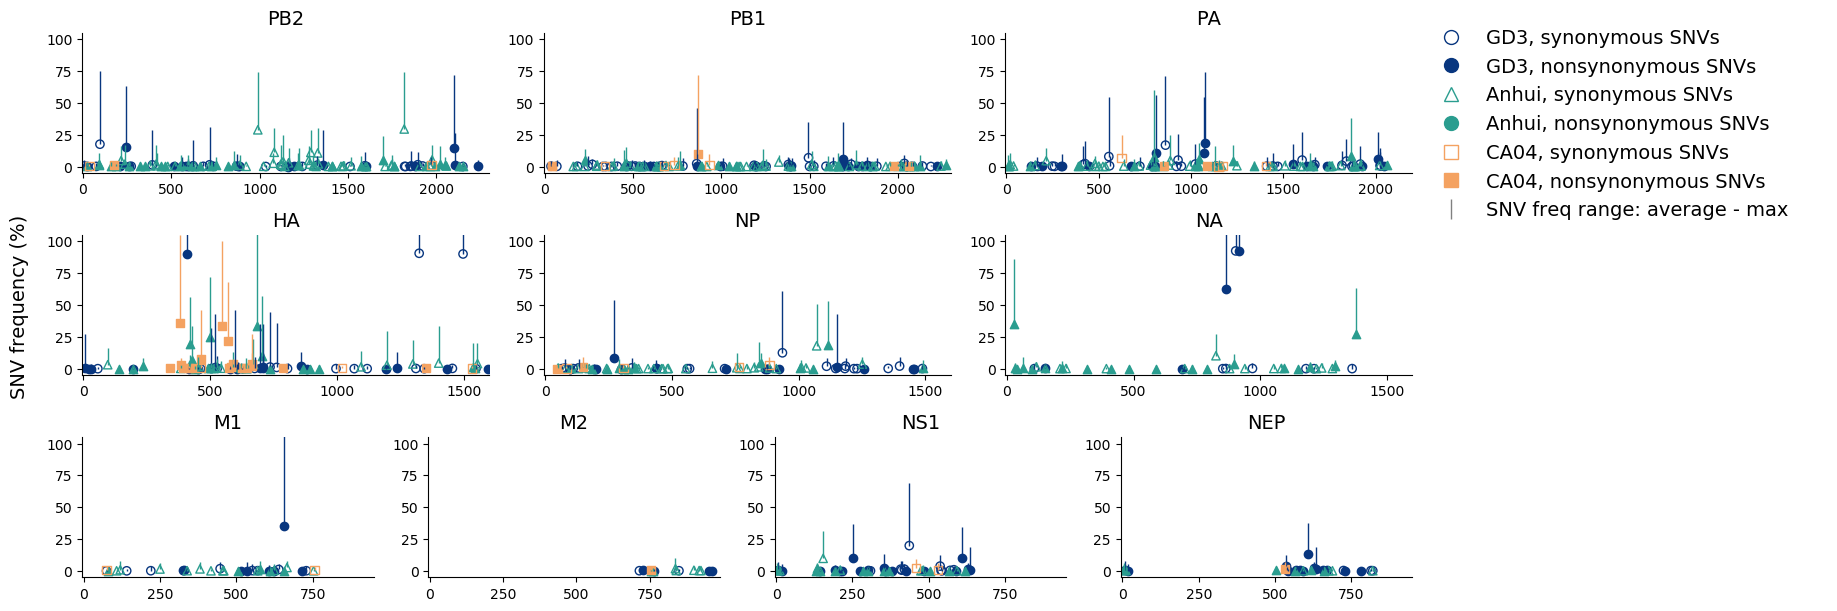

In [39]:
# define hex colors
GD3 = '#08367F'
Anhui = '#2A9D8F'
CA04 = '#F4A261'

# generate a figure with sub-plots (one for each gene segment)
fig2 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Helvetica')
gs = gridspec.GridSpec(4, 12)

ax1 = fig2.add_subplot(gs[0,0:4]) #PB2
ax2 = fig2.add_subplot(gs[0,4:8]) #PB1
ax3 = fig2.add_subplot(gs[0,8:12]) #PA
ax4 = fig2.add_subplot(gs[1,0:4]) #HA
ax5 = fig2.add_subplot(gs[1,4:8]) #NP
ax6 = fig2.add_subplot(gs[1,8:12]) #NA
ax7 = fig2.add_subplot(gs[2,0:3]) #M1
ax8 = fig2.add_subplot(gs[2,3:6]) #M2
ax9 = fig2.add_subplot(gs[2,6:9]) #NS1
ax10 = fig2.add_subplot(gs[2,9:12]) #NEP

# get right of top and right frame of each subplot
axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PB2 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('PB2', fontname='Helvetica', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
ax1.set_ylim(-5,105)
ax1.set_xlim(-5,2300)
ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.scatter(x=GD3_index_syn_PB2['loc'], y=GD3_index_syn_PB2['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax1.errorbar(x=GD3_index_syn_PB2['loc'], y=GD3_index_syn_PB2['mean'], yerr=[GD3_index_syn_PB2['min_error'], GD3_index_syn_PB2['max']], fmt='none', c=GD3, elinewidth=1)
ax1.scatter(x=GD3_index_nonsyn_PB2['loc'], y=GD3_index_nonsyn_PB2['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax1.errorbar(x=GD3_index_nonsyn_PB2['loc'], y=GD3_index_nonsyn_PB2['mean'], yerr=[GD3_index_nonsyn_PB2['min_error'], GD3_index_nonsyn_PB2['max']], fmt='none', c=GD3, elinewidth=1)
ax1.scatter(x=Anhui_index_syn_PB2['loc'], y=Anhui_index_syn_PB2['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.errorbar(x=Anhui_index_syn_PB2['loc'], y=Anhui_index_syn_PB2['mean'], yerr=[Anhui_index_syn_PB2['min_error'], Anhui_index_syn_PB2['max']], fmt='none', c=Anhui, elinewidth=1)
ax1.scatter(x=Anhui_index_nonsyn_PB2['loc'], y=Anhui_index_nonsyn_PB2['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax1.errorbar(x=Anhui_index_nonsyn_PB2['loc'], y=Anhui_index_nonsyn_PB2['mean'], yerr=[Anhui_index_nonsyn_PB2['min_error'], Anhui_index_nonsyn_PB2['max']], fmt='none', c=Anhui, elinewidth=1)
ax1.scatter(x=CA04_index_syn_PB2['loc'], y=CA04_index_syn_PB2['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax1.errorbar(x=CA04_index_syn_PB2['loc'], y=CA04_index_syn_PB2['mean'], yerr=[CA04_index_syn_PB2['min_error'], CA04_index_syn_PB2['max']], fmt='none', c=CA04, elinewidth=1)
ax1.scatter(x=CA04_index_nonsyn_PB2['loc'], y=CA04_index_nonsyn_PB2['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax1.errorbar(x=CA04_index_nonsyn_PB2['loc'], y=CA04_index_nonsyn_PB2['mean'], yerr=[CA04_index_nonsyn_PB2['min_error'], CA04_index_nonsyn_PB2['max']], fmt='none', c=CA04, elinewidth=1)

# PB1 (ax2) (GD3, Anhui, and CA04)
ax2.set_title('PB1', fontname='Helvetica', fontsize=14)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
ax2.set_ylim(-5,105)
ax2.set_xlim(-5,2300)
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.scatter(x=GD3_index_syn_PB1['loc'], y=GD3_index_syn_PB1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax2.errorbar(x=GD3_index_syn_PB1['loc'], y=GD3_index_syn_PB1['mean'], yerr=[GD3_index_syn_PB1['min_error'], GD3_index_syn_PB1['max']], fmt='none', c=GD3, elinewidth=1)
ax2.scatter(x=GD3_index_nonsyn_PB1['loc'], y=GD3_index_nonsyn_PB1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax2.errorbar(x=GD3_index_nonsyn_PB1['loc'], y=GD3_index_nonsyn_PB1['mean'], yerr=[GD3_index_nonsyn_PB1['min_error'], GD3_index_nonsyn_PB1['max']], fmt='none', c=GD3, elinewidth=1)
ax2.scatter(x=Anhui_index_syn_PB1['loc'], y=Anhui_index_syn_PB1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax2.errorbar(x=Anhui_index_syn_PB1['loc'], y=Anhui_index_syn_PB1['mean'], yerr=[Anhui_index_syn_PB1['min_error'], Anhui_index_syn_PB1['max']], fmt='none', c=Anhui, elinewidth=1)
ax2.scatter(x=Anhui_index_nonsyn_PB1['loc'], y=Anhui_index_nonsyn_PB1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax2.errorbar(x=Anhui_index_nonsyn_PB1['loc'], y=Anhui_index_nonsyn_PB1['mean'], yerr=[Anhui_index_nonsyn_PB1['min_error'], Anhui_index_nonsyn_PB1['max']], fmt='none', c=Anhui, elinewidth=1)
ax2.scatter(x=CA04_index_syn_PB1['loc'], y=CA04_index_syn_PB1['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax2.errorbar(x=CA04_index_syn_PB1['loc'], y=CA04_index_syn_PB1['mean'], yerr=[CA04_index_syn_PB1['min_error'], CA04_index_syn_PB1['max']], fmt='none', c=CA04, elinewidth=1)
ax2.scatter(x=CA04_index_nonsyn_PB1['loc'], y=CA04_index_nonsyn_PB1['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax2.errorbar(x=CA04_index_nonsyn_PB1['loc'], y=CA04_index_nonsyn_PB1['mean'], yerr=[CA04_index_nonsyn_PB1['min_error'], CA04_index_nonsyn_PB1['max']], fmt='none', c=CA04, elinewidth=1)

# PA (ax3) (GD3, Anhui, and CA04)
ax3.set_title('PA', fontname='Helvetica', fontsize=14)
for tick in ax3.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Helvetica")
ax3.set_ylim(-5,105)
ax3.set_xlim(-5,2200)
ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.scatter(x=GD3_index_syn_PA['loc'], y=GD3_index_syn_PA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax3.errorbar(x=GD3_index_syn_PA['loc'], y=GD3_index_syn_PA['mean'], yerr=[GD3_index_syn_PA['min_error'], GD3_index_syn_PA['max']], fmt='none', c=GD3, elinewidth=1)
ax3.scatter(x=GD3_index_nonsyn_PA['loc'], y=GD3_index_nonsyn_PA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax3.errorbar(x=GD3_index_nonsyn_PA['loc'], y=GD3_index_nonsyn_PA['mean'], yerr=[GD3_index_nonsyn_PA['min_error'], GD3_index_nonsyn_PA['max']], fmt='none', c=GD3, elinewidth=1)
ax3.scatter(x=Anhui_index_syn_PA['loc'], y=Anhui_index_syn_PA['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax3.errorbar(x=Anhui_index_syn_PA['loc'], y=Anhui_index_syn_PA['mean'], yerr=[Anhui_index_syn_PA['min_error'], Anhui_index_syn_PA['max']], fmt='none', c=Anhui, elinewidth=1)
ax3.scatter(x=Anhui_index_nonsyn_PA['loc'], y=Anhui_index_nonsyn_PA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax3.errorbar(x=Anhui_index_nonsyn_PA['loc'], y=Anhui_index_nonsyn_PA['mean'], yerr=[Anhui_index_nonsyn_PA['min_error'], Anhui_index_nonsyn_PA['max']], fmt='none', c=Anhui, elinewidth=1)
ax3.scatter(x=CA04_index_syn_PA['loc'], y=CA04_index_syn_PA['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax3.errorbar(x=CA04_index_syn_PA['loc'], y=CA04_index_syn_PA['mean'], yerr=[CA04_index_syn_PA['min_error'], CA04_index_syn_PA['max']], fmt='none', c=CA04, elinewidth=1)
ax3.scatter(x=CA04_index_nonsyn_PA['loc'], y=CA04_index_nonsyn_PA['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax3.errorbar(x=CA04_index_nonsyn_PA['loc'], y=CA04_index_nonsyn_PA['mean'], yerr=[CA04_index_nonsyn_PA['min_error'], CA04_index_nonsyn_PA['max']], fmt='none', c=CA04, elinewidth=1)

# HA (ax4) (GD3, Anhui, and CA04)
ax4.set_title('HA', fontname='Helvetica', fontsize=14)
for tick in ax4.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Helvetica")
ax4.set_ylim(-5,105)
ax4.set_xlim(-5,1600)
ax4.set_xticks([0, 500, 1000, 1500])
ax4.scatter(x=GD3_index_syn_HA['loc'], y=GD3_index_syn_HA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax4.errorbar(x=GD3_index_syn_HA['loc'], y=GD3_index_syn_HA['mean'], yerr=[GD3_index_syn_HA['min_error'], GD3_index_syn_HA['max']], fmt='none', c=GD3, elinewidth=1)
ax4.scatter(x=GD3_index_nonsyn_HA['loc'], y=GD3_index_nonsyn_HA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax4.errorbar(x=GD3_index_nonsyn_HA['loc'], y=GD3_index_nonsyn_HA['mean'], yerr=[GD3_index_nonsyn_HA['min_error'], GD3_index_nonsyn_HA['max']], fmt='none', c=GD3, elinewidth=1)
ax4.scatter(x=Anhui_index_syn_HA['loc'], y=Anhui_index_syn_HA['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax4.errorbar(x=Anhui_index_syn_HA['loc'], y=Anhui_index_syn_HA['mean'], yerr=[Anhui_index_syn_HA['min_error'], Anhui_index_syn_HA['max']], fmt='none', c=Anhui, elinewidth=1)
ax4.scatter(x=Anhui_index_nonsyn_HA['loc'], y=Anhui_index_nonsyn_HA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax4.errorbar(x=Anhui_index_nonsyn_HA['loc'], y=Anhui_index_nonsyn_HA['mean'], yerr=[Anhui_index_nonsyn_HA['min_error'], Anhui_index_nonsyn_HA['max']], fmt='none', c=Anhui, elinewidth=1)
ax4.scatter(x=CA04_index_syn_HA['loc'], y=CA04_index_syn_HA['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax4.errorbar(x=CA04_index_syn_HA['loc'], y=CA04_index_syn_HA['mean'], yerr=[CA04_index_syn_HA['min_error'], CA04_index_syn_HA['max']], fmt='none', c=CA04, elinewidth=1)
ax4.scatter(x=CA04_index_nonsyn_HA['loc'], y=CA04_index_nonsyn_HA['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax4.errorbar(x=CA04_index_nonsyn_HA['loc'], y=CA04_index_nonsyn_HA['mean'], yerr=[CA04_index_nonsyn_HA['min_error'], CA04_index_nonsyn_HA['max']], fmt='none', c=CA04, elinewidth=1)

# NP (ax5) (GD3, Anhui, and CA04)
ax5.set_title('NP', fontname='Helvetica', fontsize=14)
for tick in ax5.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Helvetica")
ax5.set_ylim(-5,105)
ax5.set_xlim(-5,1600)
ax5.set_xticks([0, 500, 1000, 1500])
ax5.scatter(x=GD3_index_syn_NP['loc'], y=GD3_index_syn_NP['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax5.errorbar(x=GD3_index_syn_NP['loc'], y=GD3_index_syn_NP['mean'], yerr=[GD3_index_syn_NP['min_error'], GD3_index_syn_NP['max']], fmt='none', c=GD3, elinewidth=1)
ax5.scatter(x=GD3_index_nonsyn_NP['loc'], y=GD3_index_nonsyn_NP['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax5.errorbar(x=GD3_index_nonsyn_NP['loc'], y=GD3_index_nonsyn_NP['mean'], yerr=[GD3_index_nonsyn_NP['min_error'], GD3_index_nonsyn_NP['max']], fmt='none', c=GD3, elinewidth=1)
ax5.scatter(x=Anhui_index_syn_NP['loc'], y=Anhui_index_syn_NP['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax5.errorbar(x=Anhui_index_syn_NP['loc'], y=Anhui_index_syn_NP['mean'], yerr=[Anhui_index_syn_NP['min_error'], Anhui_index_syn_NP['max']], fmt='none', c=Anhui, elinewidth=1)
ax5.scatter(x=Anhui_index_nonsyn_NP['loc'], y=Anhui_index_nonsyn_NP['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax5.errorbar(x=Anhui_index_nonsyn_NP['loc'], y=Anhui_index_nonsyn_NP['mean'], yerr=[Anhui_index_nonsyn_NP['min_error'], Anhui_index_nonsyn_NP['max']], fmt='none', c=Anhui, elinewidth=1)
ax5.scatter(x=CA04_index_syn_NP['loc'], y=CA04_index_syn_NP['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax5.errorbar(x=CA04_index_syn_NP['loc'], y=CA04_index_syn_NP['mean'], yerr=[CA04_index_syn_NP['min_error'], CA04_index_syn_NP['max']], fmt='none', c=CA04, elinewidth=1)
ax5.scatter(x=CA04_index_nonsyn_NP['loc'], y=CA04_index_nonsyn_NP['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax5.errorbar(x=CA04_index_nonsyn_NP['loc'], y=CA04_index_nonsyn_NP['mean'], yerr=[CA04_index_nonsyn_NP['min_error'], CA04_index_nonsyn_NP['max']], fmt='none', c=CA04, elinewidth=1)

# NA (ax6) (GD3, Anhui)
ax6.set_title('NA', fontname='Helvetica', fontsize=14)
for tick in ax6.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Helvetica")
ax6.set_ylim(-5,105)
ax6.set_xlim(-5,1600)
ax6.set_xticks([0, 500, 1000, 1500])
ax6.scatter(x=GD3_index_syn_NA['loc'], y=GD3_index_syn_NA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax6.errorbar(x=GD3_index_syn_NA['loc'], y=GD3_index_syn_NA['mean'], yerr=[GD3_index_syn_NA['min_error'], GD3_index_syn_NA['max']], fmt='none', c=GD3, elinewidth=1)
ax6.scatter(x=GD3_index_nonsyn_NA['loc'], y=GD3_index_nonsyn_NA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax6.errorbar(x=GD3_index_nonsyn_NA['loc'], y=GD3_index_nonsyn_NA['mean'], yerr=[GD3_index_nonsyn_NA['min_error'], GD3_index_nonsyn_NA['max']], fmt='none', c=GD3, elinewidth=1)
ax6.scatter(x=Anhui_index_syn_NA['loc'], y=Anhui_index_syn_NA['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax6.errorbar(x=Anhui_index_syn_NA['loc'], y=Anhui_index_syn_NA['mean'], yerr=[Anhui_index_syn_NA['min_error'], Anhui_index_syn_NA['max']], fmt='none', c=Anhui, elinewidth=1)
ax6.scatter(x=Anhui_index_nonsyn_NA['loc'], y=Anhui_index_nonsyn_NA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax6.errorbar(x=Anhui_index_nonsyn_NA['loc'], y=Anhui_index_nonsyn_NA['mean'], yerr=[Anhui_index_nonsyn_NA['min_error'], Anhui_index_nonsyn_NA['max']], fmt='none', c=Anhui, elinewidth=1)

# M1 (ax7) (GD3, Anhui, and CA04)
ax7.set_title('M1', fontname='Helvetica', fontsize=14)
for tick in ax7.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Helvetica")
ax7.set_ylim(-5,105)
ax7.set_xlim(-5,950)
ax7.set_xticks([0, 250, 500, 750])
ax7.scatter(x=GD3_index_syn_M1['loc'], y=GD3_index_syn_M1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax7.errorbar(x=GD3_index_syn_M1['loc'], y=GD3_index_syn_M1['mean'], yerr=[GD3_index_syn_M1['min_error'], GD3_index_syn_M1['max']], fmt='none', c=GD3, elinewidth=1)
ax7.scatter(x=GD3_index_nonsyn_M1['loc'], y=GD3_index_nonsyn_M1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax7.errorbar(x=GD3_index_nonsyn_M1['loc'], y=GD3_index_nonsyn_M1['mean'], yerr=[GD3_index_nonsyn_M1['min_error'], GD3_index_nonsyn_M1['max']], fmt='none', c=GD3, elinewidth=1)
ax7.scatter(x=Anhui_index_syn_M1['loc'], y=Anhui_index_syn_M1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax7.errorbar(x=Anhui_index_syn_M1['loc'], y=Anhui_index_syn_M1['mean'], yerr=[Anhui_index_syn_M1['min_error'], Anhui_index_syn_M1['max']], fmt='none', c=Anhui, elinewidth=1)
ax7.scatter(x=Anhui_index_nonsyn_M1['loc'], y=Anhui_index_nonsyn_M1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax7.errorbar(x=Anhui_index_nonsyn_M1['loc'], y=Anhui_index_nonsyn_M1['mean'], yerr=[Anhui_index_nonsyn_M1['min_error'], Anhui_index_nonsyn_M1['max']], fmt='none', c=Anhui, elinewidth=1)
ax7.scatter(x=CA04_index_syn_M1['loc'], y=CA04_index_syn_M1['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax7.errorbar(x=CA04_index_syn_M1['loc'], y=CA04_index_syn_M1['mean'], yerr=[CA04_index_syn_M1['min_error'], CA04_index_syn_M1['max']], fmt='none', c=CA04, elinewidth=1)

# M2 (ax8) (GD3, Anhui, and CA04)
ax8.set_title('M2', fontname='Helvetica', fontsize=14)
for tick in ax8.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Helvetica")
ax8.set_ylim(-5,105)
ax8.set_xlim(-5,990)
ax8.set_xticks([0, 250, 500, 750])
ax8.scatter(x=GD3_index_syn_M2['loc'], y=GD3_index_syn_M2['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax8.errorbar(x=GD3_index_syn_M2['loc'], y=GD3_index_syn_M2['mean'], yerr=[GD3_index_syn_M2['min_error'], GD3_index_syn_M2['max']], fmt='none', c=GD3, elinewidth=1)
ax8.scatter(x=GD3_index_nonsyn_M2['loc'], y=GD3_index_nonsyn_M2['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax8.errorbar(x=GD3_index_nonsyn_M2['loc'], y=GD3_index_nonsyn_M2['mean'], yerr=[GD3_index_nonsyn_M2['min_error'], GD3_index_nonsyn_M2['max']], fmt='none', c=GD3, elinewidth=1)
ax8.scatter(x=Anhui_index_syn_M2['loc'], y=Anhui_index_syn_M2['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax8.errorbar(x=Anhui_index_syn_M2['loc'], y=Anhui_index_syn_M2['mean'], yerr=[Anhui_index_syn_M2['min_error'], Anhui_index_syn_M2['max']], fmt='none', c=Anhui, elinewidth=1)
ax8.scatter(x=Anhui_index_nonsyn_M2['loc'], y=Anhui_index_nonsyn_M2['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax8.errorbar(x=Anhui_index_nonsyn_M2['loc'], y=Anhui_index_nonsyn_M2['mean'], yerr=[Anhui_index_nonsyn_M2['min_error'], Anhui_index_nonsyn_M2['max']], fmt='none', c=Anhui, elinewidth=1)
ax8.scatter(x=CA04_index_nonsyn_M2['loc'], y=CA04_index_nonsyn_M2['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax8.errorbar(x=CA04_index_nonsyn_M2['loc'], y=CA04_index_nonsyn_M2['mean'], yerr=[CA04_index_nonsyn_M2['min_error'], CA04_index_nonsyn_M2['max']], fmt='none', c=CA04, elinewidth=1)

# NS1 (ax9) (GD3, Anhui, and CA04)
ax9.set_title('NS1', fontname='Helvetica', fontsize=14)
for tick in ax9.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax9.get_yticklabels():
    tick.set_fontname("Helvetica")
ax9.set_ylim(-5,105)
ax9.set_xlim(-5,950)
ax9.set_xticks([0, 250, 500, 750])
ax9.scatter(x=GD3_index_syn_NS1['loc'], y=GD3_index_syn_NS1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax9.errorbar(x=GD3_index_syn_NS1['loc'], y=GD3_index_syn_NS1['mean'], yerr=[GD3_index_syn_NS1['min_error'], GD3_index_syn_NS1['max']], fmt='none', c=GD3, elinewidth=1)
ax9.scatter(x=GD3_index_nonsyn_NS1['loc'], y=GD3_index_nonsyn_NS1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax9.errorbar(x=GD3_index_nonsyn_NS1['loc'], y=GD3_index_nonsyn_NS1['mean'], yerr=[GD3_index_nonsyn_NS1['min_error'], GD3_index_nonsyn_NS1['max']], fmt='none', c=GD3, elinewidth=1)
ax9.scatter(x=Anhui_index_syn_NS1['loc'], y=Anhui_index_syn_NS1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax9.errorbar(x=Anhui_index_syn_NS1['loc'], y=Anhui_index_syn_NS1['mean'], yerr=[Anhui_index_syn_NS1['min_error'], Anhui_index_syn_NS1['max']], fmt='none', c=Anhui, elinewidth=1)
ax9.scatter(x=Anhui_index_nonsyn_NS1['loc'], y=Anhui_index_nonsyn_NS1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax9.errorbar(x=Anhui_index_nonsyn_NS1['loc'], y=Anhui_index_nonsyn_NS1['mean'], yerr=[Anhui_index_nonsyn_NS1['min_error'], Anhui_index_nonsyn_NS1['max']], fmt='none', c=Anhui, elinewidth=1)
ax9.scatter(x=CA04_index_syn_NS1['loc'], y=CA04_index_syn_NS1['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax9.errorbar(x=CA04_index_syn_NS1['loc'], y=CA04_index_syn_NS1['mean'], yerr=[CA04_index_syn_NS1['min_error'], CA04_index_syn_NS1['max']], fmt='none', c=CA04, elinewidth=1)

# NEP (ax10) (GD3, Anhui, and CA04)
ax10.set_title('NEP', fontname='Helvetica', fontsize=14)
for tick in ax10.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax10.get_yticklabels():
    tick.set_fontname("Helvetica")
ax10.set_ylim(-5,105)
ax10.set_xlim(-5,950)
ax10.set_xticks([0, 250, 500, 750])
ax10.scatter(x=GD3_index_syn_NEP['loc'], y=GD3_index_syn_NEP['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax10.errorbar(x=GD3_index_syn_NEP['loc'], y=GD3_index_syn_NEP['mean'], yerr=[GD3_index_syn_NEP['min_error'], GD3_index_syn_NEP['max']], fmt='none', c=GD3, elinewidth=1)
ax10.scatter(x=GD3_index_nonsyn_NEP['loc'], y=GD3_index_nonsyn_NEP['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax10.errorbar(x=GD3_index_nonsyn_NEP['loc'], y=GD3_index_nonsyn_NEP['mean'], yerr=[GD3_index_nonsyn_NEP['min_error'], GD3_index_nonsyn_NEP['max']], fmt='none', c=GD3, elinewidth=1)
ax10.scatter(x=Anhui_index_syn_NEP['loc'], y=Anhui_index_syn_NEP['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax10.errorbar(x=Anhui_index_syn_NEP['loc'], y=Anhui_index_syn_NEP['mean'], yerr=[Anhui_index_syn_NEP['min_error'], Anhui_index_syn_NEP['max']], fmt='none', c=Anhui, elinewidth=1)
ax10.scatter(x=Anhui_index_nonsyn_NEP['loc'], y=Anhui_index_nonsyn_NEP['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax10.errorbar(x=Anhui_index_nonsyn_NEP['loc'], y=Anhui_index_nonsyn_NEP['mean'], yerr=[Anhui_index_nonsyn_NEP['min_error'], Anhui_index_nonsyn_NEP['max']], fmt='none', c=Anhui, elinewidth=1)
ax10.scatter(x=CA04_index_nonsyn_NEP['loc'], y=CA04_index_nonsyn_NEP['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax10.errorbar(x=CA04_index_nonsyn_NEP['loc'], y=CA04_index_nonsyn_NEP['mean'], yerr=[CA04_index_nonsyn_NEP['min_error'], CA04_index_nonsyn_NEP['max']], fmt='none', c=CA04, elinewidth=1)

# add a common x axis label for the entire figure 
fig2.text(-0.015, 0.61, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Helvetica')

# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous SNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous SNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous SNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous SNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous SNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous SNVs')
line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig2.legend(handles=[GD3_syn, GD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn, line], frameon=False, fontsize=14, bbox_to_anchor=(1.29,0.75))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig2.tight_layout()
fig2.show()

# save this plot to the figures folder 
fig2.savefig("../figures/figure2A.pdf", bbox_inches='tight', dpi=300)

###

In [40]:
# to specify color and dataplot type in the plots below, I need to rename all of the DFs in the lists generated above
# according to their gene segment so I can specific which type of data should go on each plot
# PB2 
GD3_contact_syn_PB2 = GD3_contact_syn[0]
GD3_contact_nonsyn_PB2 = GD3_contact_nonsyn[0]
Anhui_contact_nonsyn_PB2 = Anhui_contact_nonsyn[0]
Anhui_contact_syn_PB2 = Anhui_contact_syn[0]
CA04_contact_nonsyn_PB2 = CA04_contact_nonsyn[0]
CA04_contact_syn_PB2 = CA04_contact_syn[0]

# PB1 
GD3_contact_syn_PB1 = GD3_contact_syn[1]
GD3_contact_nonsyn_PB1 = GD3_contact_nonsyn[1]
Anhui_contact_nonsyn_PB1 = Anhui_contact_nonsyn[1]
Anhui_contact_syn_PB1 = Anhui_contact_syn[1]
CA04_contact_nonsyn_PB1 = CA04_contact_nonsyn[1]
CA04_contact_syn_PB1 = CA04_contact_syn[1]

# PA 
GD3_contact_syn_PA = GD3_contact_syn[2]
GD3_contact_nonsyn_PA = GD3_contact_nonsyn[2]
Anhui_contact_nonsyn_PA = Anhui_contact_nonsyn[2]
Anhui_contact_syn_PA = Anhui_contact_syn[2]
CA04_contact_nonsyn_PA = CA04_contact_nonsyn[2]
CA04_contact_syn_PA = CA04_contact_syn[2]

# HA 
GD3_contact_syn_HA = GD3_contact_syn[3]
GD3_contact_nonsyn_HA = GD3_contact_nonsyn[3]
Anhui_contact_nonsyn_HA = Anhui_contact_nonsyn[3]
Anhui_contact_syn_HA = Anhui_contact_syn[3]
CA04_contact_nonsyn_HA = CA04_contact_nonsyn[3]
CA04_contact_syn_HA = CA04_contact_syn[3]

# NP 
GD3_contact_syn_NP = GD3_contact_syn[4]
GD3_contact_nonsyn_NP = GD3_contact_nonsyn[4]
Anhui_contact_nonsyn_NP = Anhui_contact_nonsyn[4]
Anhui_contact_syn_NP = Anhui_contact_syn[4]
CA04_contact_nonsyn_NP = CA04_contact_nonsyn[4]
CA04_contact_syn_NP = CA04_contact_syn[4]

# NA 
GD3_contact_syn_NA = GD3_contact_syn[5]
GD3_contact_nonsyn_NA = GD3_contact_nonsyn[5]
Anhui_contact_nonsyn_NA = Anhui_contact_nonsyn[5]
Anhui_contact_syn_NA = Anhui_contact_syn[5]
CA04_contact_nonsyn_NA = CA04_contact_nonsyn[5]
CA04_contact_syn_NA = CA04_contact_syn[5]

# M1 
GD3_contact_syn_M1 = GD3_contact_syn[6]
GD3_contact_nonsyn_M1 = GD3_contact_nonsyn[6]
Anhui_contact_nonsyn_M1 = Anhui_contact_nonsyn[6]
Anhui_contact_syn_M1 = Anhui_contact_syn[6]
CA04_contact_nonsyn_M1 = CA04_contact_nonsyn[6]
CA04_contact_syn_M1 = CA04_contact_syn[6]

# M2 
GD3_contact_syn_M2 = GD3_contact_syn[7]
GD3_contact_nonsyn_M2 = GD3_contact_nonsyn[7]
Anhui_contact_nonsyn_M2 = Anhui_contact_nonsyn[7]
Anhui_contact_syn_M2 = Anhui_contact_syn[7]
CA04_contact_nonsyn_M2 = CA04_contact_nonsyn[7]
CA04_contact_syn_M2 = CA04_contact_syn[7]

# NS1 
GD3_contact_syn_NS1 = GD3_contact_syn[8]
GD3_contact_nonsyn_NS1 = GD3_contact_nonsyn[8]
Anhui_contact_nonsyn_NS1 = Anhui_contact_nonsyn[8]
Anhui_contact_syn_NS1 = Anhui_contact_syn[8]
CA04_contact_nonsyn_NS1 = CA04_contact_nonsyn[8]
CA04_contact_syn_NS1 = CA04_contact_syn[8]

# NEP
GD3_contact_syn_NEP = GD3_contact_syn[9]
GD3_contact_nonsyn_NEP = GD3_contact_nonsyn[9]
Anhui_contact_nonsyn_NEP = Anhui_contact_nonsyn[9]
Anhui_contact_syn_NEP = Anhui_contact_syn[9]
CA04_contact_nonsyn_NEP = CA04_contact_nonsyn[9]
CA04_contact_syn_NEP = CA04_contact_syn[9]

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


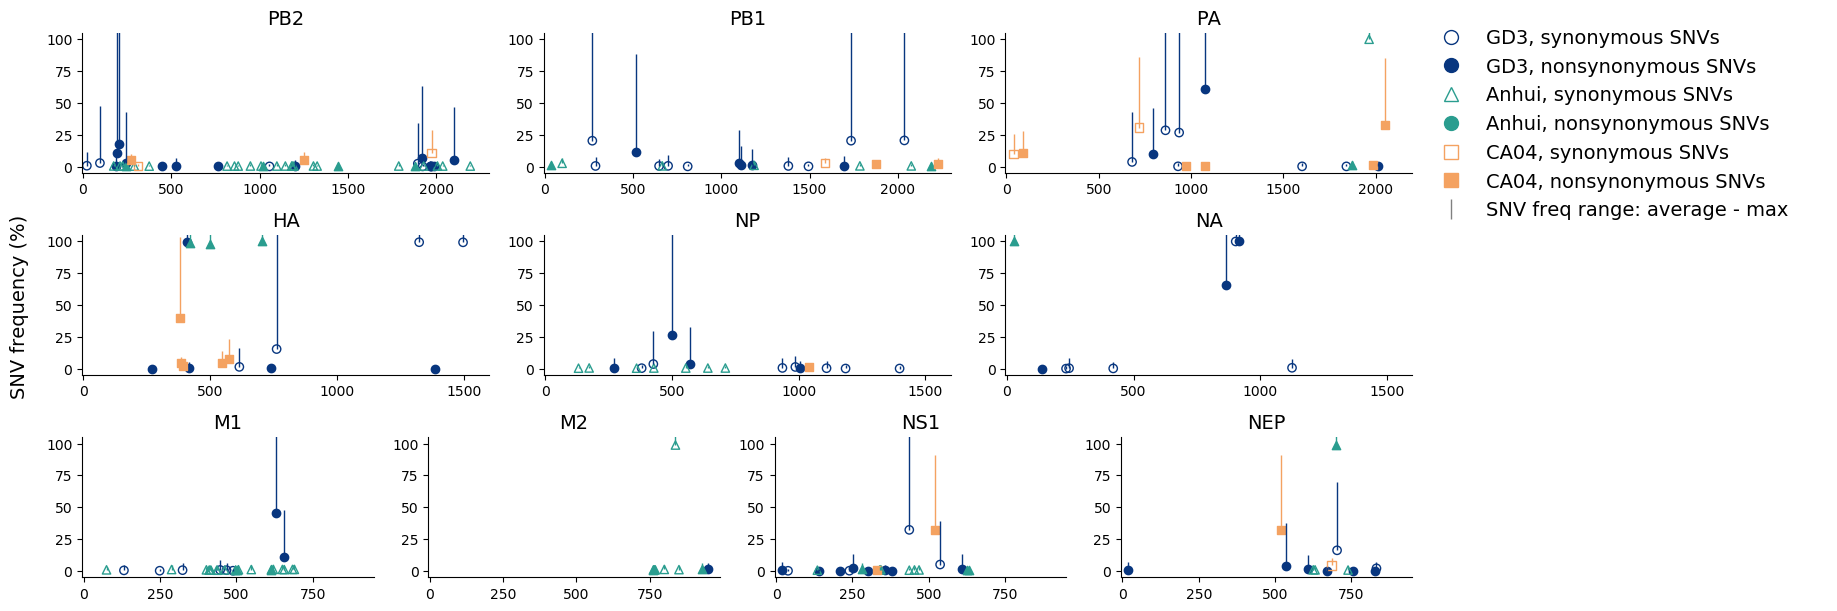

In [41]:
# define hex colors
GD3 = '#08367F'
Anhui = '#2A9D8F'
CA04 = '#F4A261'

# generate a figure with sub-plots (one for each gene segment)
fig2 = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Helvetica')
gs = gridspec.GridSpec(4, 12)

ax1 = fig2.add_subplot(gs[0,0:4]) #PB2
ax2 = fig2.add_subplot(gs[0,4:8]) #PB1
ax3 = fig2.add_subplot(gs[0,8:12]) #PA
ax4 = fig2.add_subplot(gs[1,0:4]) #HA
ax5 = fig2.add_subplot(gs[1,4:8]) #NP
ax6 = fig2.add_subplot(gs[1,8:12]) #NA
ax7 = fig2.add_subplot(gs[2,0:3]) #M1
ax8 = fig2.add_subplot(gs[2,3:6]) #M2
ax9 = fig2.add_subplot(gs[2,6:9]) #NS1
ax10 = fig2.add_subplot(gs[2,9:12]) #NEP

# get right of top and right frame of each subplot
axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 10)

# PB2 (ax1) (GD3, Anhui, and CA04)
ax1.set_title('PB2', fontname='Helvetica', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
ax1.set_ylim(-5,105)
ax1.set_xlim(-5,2300)
ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.scatter(x=GD3_contact_syn_PB2['loc'], y=GD3_contact_syn_PB2['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax1.errorbar(x=GD3_contact_syn_PB2['loc'], y=GD3_contact_syn_PB2['mean'], yerr=[GD3_contact_syn_PB2['min_error'], GD3_contact_syn_PB2['max']], fmt='none', c=GD3, elinewidth=1)
ax1.scatter(x=GD3_contact_nonsyn_PB2['loc'], y=GD3_contact_nonsyn_PB2['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax1.errorbar(x=GD3_contact_nonsyn_PB2['loc'], y=GD3_contact_nonsyn_PB2['mean'], yerr=[GD3_contact_nonsyn_PB2['min_error'], GD3_contact_nonsyn_PB2['max']], fmt='none', c=GD3, elinewidth=1)
ax1.scatter(x=Anhui_contact_syn_PB2['loc'], y=Anhui_contact_syn_PB2['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax1.errorbar(x=Anhui_contact_syn_PB2['loc'], y=Anhui_contact_syn_PB2['mean'], yerr=[Anhui_contact_syn_PB2['min_error'], Anhui_contact_syn_PB2['max']], fmt='none', c=Anhui, elinewidth=1)
ax1.scatter(x=Anhui_contact_nonsyn_PB2['loc'], y=Anhui_contact_nonsyn_PB2['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax1.errorbar(x=Anhui_contact_nonsyn_PB2['loc'], y=Anhui_contact_nonsyn_PB2['mean'], yerr=[Anhui_contact_nonsyn_PB2['min_error'], Anhui_contact_nonsyn_PB2['max']], fmt='none', c=Anhui, elinewidth=1)
ax1.scatter(x=CA04_contact_syn_PB2['loc'], y=CA04_contact_syn_PB2['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax1.errorbar(x=CA04_contact_syn_PB2['loc'], y=CA04_contact_syn_PB2['mean'], yerr=[CA04_contact_syn_PB2['min_error'], CA04_contact_syn_PB2['max']], fmt='none', c=CA04, elinewidth=1)
ax1.scatter(x=CA04_contact_nonsyn_PB2['loc'], y=CA04_contact_nonsyn_PB2['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax1.errorbar(x=CA04_contact_nonsyn_PB2['loc'], y=CA04_contact_nonsyn_PB2['mean'], yerr=[CA04_contact_nonsyn_PB2['min_error'], CA04_contact_nonsyn_PB2['max']], fmt='none', c=CA04, elinewidth=1)

# PB1 (ax2) (GD3, Anhui, and CA04)
ax2.set_title('PB1', fontname='Helvetica', fontsize=14)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
ax2.set_ylim(-5,105)
ax2.set_xlim(-5,2300)
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.scatter(x=GD3_contact_syn_PB1['loc'], y=GD3_contact_syn_PB1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax2.errorbar(x=GD3_contact_syn_PB1['loc'], y=GD3_contact_syn_PB1['mean'], yerr=[GD3_contact_syn_PB1['min_error'], GD3_contact_syn_PB1['max']], fmt='none', c=GD3, elinewidth=1)
ax2.scatter(x=GD3_contact_nonsyn_PB1['loc'], y=GD3_contact_nonsyn_PB1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax2.errorbar(x=GD3_contact_nonsyn_PB1['loc'], y=GD3_contact_nonsyn_PB1['mean'], yerr=[GD3_contact_nonsyn_PB1['min_error'], GD3_contact_nonsyn_PB1['max']], fmt='none', c=GD3, elinewidth=1)
ax2.scatter(x=Anhui_contact_syn_PB1['loc'], y=Anhui_contact_syn_PB1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax2.errorbar(x=Anhui_contact_syn_PB1['loc'], y=Anhui_contact_syn_PB1['mean'], yerr=[Anhui_contact_syn_PB1['min_error'], Anhui_contact_syn_PB1['max']], fmt='none', c=Anhui, elinewidth=1)
ax2.scatter(x=Anhui_contact_nonsyn_PB1['loc'], y=Anhui_contact_nonsyn_PB1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax2.errorbar(x=Anhui_contact_nonsyn_PB1['loc'], y=Anhui_contact_nonsyn_PB1['mean'], yerr=[Anhui_contact_nonsyn_PB1['min_error'], Anhui_contact_nonsyn_PB1['max']], fmt='none', c=Anhui, elinewidth=1)
ax2.scatter(x=CA04_contact_syn_PB1['loc'], y=CA04_contact_syn_PB1['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax2.errorbar(x=CA04_contact_syn_PB1['loc'], y=CA04_contact_syn_PB1['mean'], yerr=[CA04_contact_syn_PB1['min_error'], CA04_contact_syn_PB1['max']], fmt='none', c=CA04, elinewidth=1)
ax2.scatter(x=CA04_contact_nonsyn_PB1['loc'], y=CA04_contact_nonsyn_PB1['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax2.errorbar(x=CA04_contact_nonsyn_PB1['loc'], y=CA04_contact_nonsyn_PB1['mean'], yerr=[CA04_contact_nonsyn_PB1['min_error'], CA04_contact_nonsyn_PB1['max']], fmt='none', c=CA04, elinewidth=1)

# PA (ax3) (GD3, Anhui, and CA04)
ax3.set_title('PA', fontname='Helvetica', fontsize=14)
for tick in ax3.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Helvetica")
ax3.set_ylim(-5,105)
ax3.set_xlim(-5,2200)
ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.scatter(x=GD3_contact_syn_PA['loc'], y=GD3_contact_syn_PA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax3.errorbar(x=GD3_contact_syn_PA['loc'], y=GD3_contact_syn_PA['mean'], yerr=[GD3_contact_syn_PA['min_error'], GD3_contact_syn_PA['max']], fmt='none', c=GD3, elinewidth=1)
ax3.scatter(x=GD3_contact_nonsyn_PA['loc'], y=GD3_contact_nonsyn_PA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax3.errorbar(x=GD3_contact_nonsyn_PA['loc'], y=GD3_contact_nonsyn_PA['mean'], yerr=[GD3_contact_nonsyn_PA['min_error'], GD3_contact_nonsyn_PA['max']], fmt='none', c=GD3, elinewidth=1)
ax3.scatter(x=Anhui_contact_syn_PA['loc'], y=Anhui_contact_syn_PA['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax3.errorbar(x=Anhui_contact_syn_PA['loc'], y=Anhui_contact_syn_PA['mean'], yerr=[Anhui_contact_syn_PA['min_error'], Anhui_contact_syn_PA['max']], fmt='none', c=Anhui, elinewidth=1)
ax3.scatter(x=Anhui_contact_nonsyn_PA['loc'], y=Anhui_contact_nonsyn_PA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax3.errorbar(x=Anhui_contact_nonsyn_PA['loc'], y=Anhui_contact_nonsyn_PA['mean'], yerr=[Anhui_contact_nonsyn_PA['min_error'], Anhui_contact_nonsyn_PA['max']], fmt='none', c=Anhui, elinewidth=1)
ax3.scatter(x=CA04_contact_syn_PA['loc'], y=CA04_contact_syn_PA['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax3.errorbar(x=CA04_contact_syn_PA['loc'], y=CA04_contact_syn_PA['mean'], yerr=[CA04_contact_syn_PA['min_error'], CA04_contact_syn_PA['max']], fmt='none', c=CA04, elinewidth=1)
ax3.scatter(x=CA04_contact_nonsyn_PA['loc'], y=CA04_contact_nonsyn_PA['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax3.errorbar(x=CA04_contact_nonsyn_PA['loc'], y=CA04_contact_nonsyn_PA['mean'], yerr=[CA04_contact_nonsyn_PA['min_error'], CA04_contact_nonsyn_PA['max']], fmt='none', c=CA04, elinewidth=1)

# HA (ax4) (GD3, Anhui, and CA04)
ax4.set_title('HA', fontname='Helvetica', fontsize=14)
for tick in ax4.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax4.get_yticklabels():
    tick.set_fontname("Helvetica")
ax4.set_ylim(-5,105)
ax4.set_xlim(-5,1600)
ax4.set_xticks([0, 500, 1000, 1500])
ax4.scatter(x=GD3_contact_syn_HA['loc'], y=GD3_contact_syn_HA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax4.errorbar(x=GD3_contact_syn_HA['loc'], y=GD3_contact_syn_HA['mean'], yerr=[GD3_contact_syn_HA['min_error'], GD3_contact_syn_HA['max']], fmt='none', c=GD3, elinewidth=1)
ax4.scatter(x=GD3_contact_nonsyn_HA['loc'], y=GD3_contact_nonsyn_HA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax4.errorbar(x=GD3_contact_nonsyn_HA['loc'], y=GD3_contact_nonsyn_HA['mean'], yerr=[GD3_contact_nonsyn_HA['min_error'], GD3_contact_nonsyn_HA['max']], fmt='none', c=GD3, elinewidth=1)
ax4.scatter(x=Anhui_contact_nonsyn_HA['loc'], y=Anhui_contact_nonsyn_HA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax4.errorbar(x=Anhui_contact_nonsyn_HA['loc'], y=Anhui_contact_nonsyn_HA['mean'], yerr=[Anhui_contact_nonsyn_HA['min_error'], Anhui_contact_nonsyn_HA['max']], fmt='none', c=Anhui, elinewidth=1)
ax4.scatter(x=CA04_contact_nonsyn_HA['loc'], y=CA04_contact_nonsyn_HA['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax4.errorbar(x=CA04_contact_nonsyn_HA['loc'], y=CA04_contact_nonsyn_HA['mean'], yerr=[CA04_contact_nonsyn_HA['min_error'], CA04_contact_nonsyn_HA['max']], fmt='none', c=CA04, elinewidth=1)

# NP (ax5) (GD3, Anhui, and CA04)
ax5.set_title('NP', fontname='Helvetica', fontsize=14)
for tick in ax5.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax5.get_yticklabels():
    tick.set_fontname("Helvetica")
ax5.set_ylim(-5,105)
ax5.set_xlim(-5,1600)
ax5.set_xticks([0, 500, 1000, 1500])
ax5.scatter(x=GD3_contact_syn_NP['loc'], y=GD3_contact_syn_NP['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax5.errorbar(x=GD3_contact_syn_NP['loc'], y=GD3_contact_syn_NP['mean'], yerr=[GD3_contact_syn_NP['min_error'], GD3_contact_syn_NP['max']], fmt='none', c=GD3, elinewidth=1)
ax5.scatter(x=GD3_contact_nonsyn_NP['loc'], y=GD3_contact_nonsyn_NP['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax5.errorbar(x=GD3_contact_nonsyn_NP['loc'], y=GD3_contact_nonsyn_NP['mean'], yerr=[GD3_contact_nonsyn_NP['min_error'], GD3_contact_nonsyn_NP['max']], fmt='none', c=GD3, elinewidth=1)
ax5.scatter(x=Anhui_contact_syn_NP['loc'], y=Anhui_contact_syn_NP['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax5.errorbar(x=Anhui_contact_syn_NP['loc'], y=Anhui_contact_syn_NP['mean'], yerr=[Anhui_contact_syn_NP['min_error'], Anhui_contact_syn_NP['max']], fmt='none', c=Anhui, elinewidth=1)
ax5.scatter(x=CA04_contact_nonsyn_NP['loc'], y=CA04_contact_nonsyn_NP['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax5.errorbar(x=CA04_contact_nonsyn_NP['loc'], y=CA04_contact_nonsyn_NP['mean'], yerr=[CA04_contact_nonsyn_NP['min_error'], CA04_contact_nonsyn_NP['max']], fmt='none', c=CA04, elinewidth=1)

# NA (ax6) (GD3, Anhui)
ax6.set_title('NA', fontname='Helvetica', fontsize=14)
for tick in ax6.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax6.get_yticklabels():
    tick.set_fontname("Helvetica")
ax6.set_ylim(-5,105)
ax6.set_xlim(-5,1600)
ax6.set_xticks([0, 500, 1000, 1500])
ax6.scatter(x=GD3_contact_syn_NA['loc'], y=GD3_contact_syn_NA['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax6.errorbar(x=GD3_contact_syn_NA['loc'], y=GD3_contact_syn_NA['mean'], yerr=[GD3_contact_syn_NA['min_error'], GD3_contact_syn_NA['max']], fmt='none', c=GD3, elinewidth=1)
ax6.scatter(x=GD3_contact_nonsyn_NA['loc'], y=GD3_contact_nonsyn_NA['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax6.errorbar(x=GD3_contact_nonsyn_NA['loc'], y=GD3_contact_nonsyn_NA['mean'], yerr=[GD3_contact_nonsyn_NA['min_error'], GD3_contact_nonsyn_NA['max']], fmt='none', c=GD3, elinewidth=1)
ax6.scatter(x=Anhui_contact_nonsyn_NA['loc'], y=Anhui_contact_nonsyn_NA['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax6.errorbar(x=Anhui_contact_nonsyn_NA['loc'], y=Anhui_contact_nonsyn_NA['mean'], yerr=[Anhui_contact_nonsyn_NA['min_error'], Anhui_contact_nonsyn_NA['max']], fmt='none', c=Anhui, elinewidth=1)

# M1 (ax7) (GD3, Anhui, and CA04)
ax7.set_title('M1', fontname='Helvetica', fontsize=14)
for tick in ax7.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax7.get_yticklabels():
    tick.set_fontname("Helvetica")
ax7.set_ylim(-5,105)
ax7.set_xlim(-5,950)
ax7.set_xticks([0, 250, 500, 750])
ax7.scatter(x=GD3_contact_syn_M1['loc'], y=GD3_contact_syn_M1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax7.errorbar(x=GD3_contact_syn_M1['loc'], y=GD3_contact_syn_M1['mean'], yerr=[GD3_contact_syn_M1['min_error'], GD3_contact_syn_M1['max']], fmt='none', c=GD3, elinewidth=1)
ax7.scatter(x=GD3_contact_nonsyn_M1['loc'], y=GD3_contact_nonsyn_M1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax7.errorbar(x=GD3_contact_nonsyn_M1['loc'], y=GD3_contact_nonsyn_M1['mean'], yerr=[GD3_contact_nonsyn_M1['min_error'], GD3_contact_nonsyn_M1['max']], fmt='none', c=GD3, elinewidth=1)
ax7.scatter(x=Anhui_contact_syn_M1['loc'], y=Anhui_contact_syn_M1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax7.errorbar(x=Anhui_contact_syn_M1['loc'], y=Anhui_contact_syn_M1['mean'], yerr=[Anhui_contact_syn_M1['min_error'], Anhui_contact_syn_M1['max']], fmt='none', c=Anhui, elinewidth=1)
ax7.scatter(x=Anhui_contact_nonsyn_M1['loc'], y=Anhui_contact_nonsyn_M1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax7.errorbar(x=Anhui_contact_nonsyn_M1['loc'], y=Anhui_contact_nonsyn_M1['mean'], yerr=[Anhui_contact_nonsyn_M1['min_error'], Anhui_contact_nonsyn_M1['max']], fmt='none', c=Anhui, elinewidth=1)

# M2 (ax8) (GD3, Anhui, and CA04)
ax8.set_title('M2', fontname='Helvetica', fontsize=14)
for tick in ax8.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax8.get_yticklabels():
    tick.set_fontname("Helvetica")
ax8.set_ylim(-5,105)
ax8.set_xlim(-5,990)
ax8.set_xticks([0, 250, 500, 750])
ax8.scatter(x=GD3_contact_nonsyn_M2['loc'], y=GD3_contact_nonsyn_M2['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax8.errorbar(x=GD3_contact_nonsyn_M2['loc'], y=GD3_contact_nonsyn_M2['mean'], yerr=[GD3_contact_nonsyn_M2['min_error'], GD3_contact_nonsyn_M2['max']], fmt='none', c=GD3, elinewidth=1)
ax8.scatter(x=Anhui_contact_syn_M2['loc'], y=Anhui_contact_syn_M2['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax8.errorbar(x=Anhui_contact_syn_M2['loc'], y=Anhui_contact_syn_M2['mean'], yerr=[Anhui_contact_syn_M2['min_error'], Anhui_contact_syn_M2['max']], fmt='none', c=Anhui, elinewidth=1)
ax8.scatter(x=Anhui_contact_nonsyn_M2['loc'], y=Anhui_contact_nonsyn_M2['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax8.errorbar(x=Anhui_contact_nonsyn_M2['loc'], y=Anhui_contact_nonsyn_M2['mean'], yerr=[Anhui_contact_nonsyn_M2['min_error'], Anhui_contact_nonsyn_M2['max']], fmt='none', c=Anhui, elinewidth=1)

# NS1 (ax9) (GD3, Anhui, and CA04)
ax9.set_title('NS1', fontname='Helvetica', fontsize=14)
for tick in ax9.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax9.get_yticklabels():
    tick.set_fontname("Helvetica")
ax9.set_ylim(-5,105)
ax9.set_xlim(-5,950)
ax9.set_xticks([0, 250, 500, 750])
ax9.scatter(x=GD3_contact_syn_NS1['loc'], y=GD3_contact_syn_NS1['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax9.errorbar(x=GD3_contact_syn_NS1['loc'], y=GD3_contact_syn_NS1['mean'], yerr=[GD3_contact_syn_NS1['min_error'], GD3_contact_syn_NS1['max']], fmt='none', c=GD3, elinewidth=1)
ax9.scatter(x=GD3_contact_nonsyn_NS1['loc'], y=GD3_contact_nonsyn_NS1['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax9.errorbar(x=GD3_contact_nonsyn_NS1['loc'], y=GD3_contact_nonsyn_NS1['mean'], yerr=[GD3_contact_nonsyn_NS1['min_error'], GD3_contact_nonsyn_NS1['max']], fmt='none', c=GD3, elinewidth=1)
ax9.scatter(x=Anhui_contact_syn_NS1['loc'], y=Anhui_contact_syn_NS1['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax9.errorbar(x=Anhui_contact_syn_NS1['loc'], y=Anhui_contact_syn_NS1['mean'], yerr=[Anhui_contact_syn_NS1['min_error'], Anhui_contact_syn_NS1['max']], fmt='none', c=Anhui, elinewidth=1)
ax9.scatter(x=Anhui_contact_nonsyn_NS1['loc'], y=Anhui_contact_nonsyn_NS1['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax9.errorbar(x=Anhui_contact_nonsyn_NS1['loc'], y=Anhui_contact_nonsyn_NS1['mean'], yerr=[Anhui_contact_nonsyn_NS1['min_error'], Anhui_contact_nonsyn_NS1['max']], fmt='none', c=Anhui, elinewidth=1)
ax9.scatter(x=CA04_contact_nonsyn_NS1['loc'], y=CA04_contact_nonsyn_NS1['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax9.errorbar(x=CA04_contact_nonsyn_NS1['loc'], y=CA04_contact_nonsyn_NS1['mean'], yerr=[CA04_contact_nonsyn_NS1['min_error'], CA04_contact_nonsyn_NS1['max']], fmt='none', c=CA04, elinewidth=1)

# NEP (ax10) (GD3, Anhui, and CA04)
ax10.set_title('NEP', fontname='Helvetica', fontsize=14)
for tick in ax10.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax10.get_yticklabels():
    tick.set_fontname("Helvetica")
ax10.set_ylim(-5,105)
ax10.set_xlim(-5,950)
ax10.set_xticks([0, 250, 500, 750])
ax10.scatter(x=GD3_contact_syn_NEP['loc'], y=GD3_contact_syn_NEP['mean'], marker='o', facecolors='none', edgecolors=GD3)
ax10.errorbar(x=GD3_contact_syn_NEP['loc'], y=GD3_contact_syn_NEP['mean'], yerr=[GD3_contact_syn_NEP['min_error'], GD3_contact_syn_NEP['max']], fmt='none', c=GD3, elinewidth=1)
ax10.scatter(x=GD3_contact_nonsyn_NEP['loc'], y=GD3_contact_nonsyn_NEP['mean'], marker='o', facecolors=GD3, edgecolors=GD3)
ax10.errorbar(x=GD3_contact_nonsyn_NEP['loc'], y=GD3_contact_nonsyn_NEP['mean'], yerr=[GD3_contact_nonsyn_NEP['min_error'], GD3_contact_nonsyn_NEP['max']], fmt='none', c=GD3, elinewidth=1)
ax10.scatter(x=Anhui_contact_syn_NEP['loc'], y=Anhui_contact_syn_NEP['mean'], marker='^', facecolors='none', edgecolors=Anhui)
ax10.errorbar(x=Anhui_contact_syn_NEP['loc'], y=Anhui_contact_syn_NEP['mean'], yerr=[Anhui_contact_syn_NEP['min_error'], Anhui_contact_syn_NEP['max']], fmt='none', c=Anhui, elinewidth=1)
ax10.scatter(x=Anhui_contact_nonsyn_NEP['loc'], y=Anhui_contact_nonsyn_NEP['mean'], marker='^', facecolors=Anhui, edgecolors=Anhui)
ax10.errorbar(x=Anhui_contact_nonsyn_NEP['loc'], y=Anhui_contact_nonsyn_NEP['mean'], yerr=[Anhui_contact_nonsyn_NEP['min_error'], Anhui_contact_nonsyn_NEP['max']], fmt='none', c=Anhui, elinewidth=1)
ax10.scatter(x=CA04_contact_syn_NEP['loc'], y=CA04_contact_syn_NEP['mean'], marker='s', facecolors='none', edgecolors=CA04)
ax10.errorbar(x=CA04_contact_syn_NEP['loc'], y=CA04_contact_syn_NEP['mean'], yerr=[CA04_contact_syn_NEP['min_error'], CA04_contact_syn_NEP['max']], fmt='none', c=CA04, elinewidth=1)
ax10.scatter(x=CA04_contact_nonsyn_NEP['loc'], y=CA04_contact_nonsyn_NEP['mean'], marker='s', facecolors=CA04, edgecolors=CA04)
ax10.errorbar(x=CA04_contact_nonsyn_NEP['loc'], y=CA04_contact_nonsyn_NEP['mean'], yerr=[CA04_contact_nonsyn_NEP['min_error'], CA04_contact_nonsyn_NEP['max']], fmt='none', c=CA04, elinewidth=1)

# add a common x axis label for the entire figure 
fig2.text(-0.015, 0.61, 'SNV frequency (%)', va='center', rotation='vertical', fontsize=14, fontname='Helvetica')

# add a legend to this plot
GD3_syn = mlines.Line2D([], [], marker='o', markerfacecolor='None', markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, synonymous SNVs')
GD3_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=GD3, markeredgecolor=GD3, linestyle='None', markersize=10, label='GD3, nonsynonymous SNVs')
Anhui_syn = mlines.Line2D([], [], marker='^', markerfacecolor='None', markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, synonymous SNVs')
Anhui_nonsyn = mlines.Line2D([], [], marker='o', markerfacecolor=Anhui, markeredgecolor=Anhui, linestyle='None', markersize=10, label='Anhui, nonsynonymous SNVs')
CA04_syn = mlines.Line2D([], [], marker='s', markerfacecolor='None', markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, synonymous SNVs')
CA04_nonsyn = mlines.Line2D([], [], marker='s', markerfacecolor=CA04, markeredgecolor=CA04, linestyle='None', markersize=10, label='CA04, nonsynonymous SNVs')
line = mlines.Line2D([], [], marker='|', linestyle='None', color='grey', label='SNV freq range: average - max', markersize=14)
fig2.legend(handles=[GD3_syn, GD3_nonsyn, Anhui_syn, Anhui_nonsyn, CA04_syn, CA04_nonsyn, line], frameon=False, fontsize=14, bbox_to_anchor=(1.29,0.75))

# use tight_layout to optimize spacing of axes and titles within each subplot
fig2.tight_layout()
fig2.show()

# save this plot to the figures folder 
fig2.savefig("../figures/figure2B.pdf", bbox_inches='tight', dpi=300)

###